# Kaggle Housing Price Competition

- [Run in Google Colab](https://colab.research.google.com/github/druce/iowa/blob/master/iowa)
- [Competition leaderboard](https://www.kaggle.com/c/home-data-for-ml-course/leaderboard)
- [Data set discussion](http://jse.amstat.org/v19n3/decock.pdf)
- [Data documentation](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)

In [65]:
from itertools import product
import operator        
import datetime
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import seaborn as sns
import pandas_profiling as pdf

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, lars_path, ElasticNet, ElasticNetCV, Ridge, RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# pointer to scaler I want to use to easily swap scalers
use_transform = RobustScaler

# not used
def mytransform():
    return QuantileTransformer(output_distribution='normal')

import scipy.stats as stats
from scipy.stats import skew  
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

#!conda install -y -c conda-forge  xgboost 
import xgboost
from xgboost import XGBRegressor
from xgboost import plot_importance

#!conda install -y -c conda-forge lightgbm
import lightgbm
from lightgbm import LGBMRegressor

#!conda install -y -c districtdatalabs yellowbrick
import yellowbrick
from yellowbrick.features import JointPlotVisualizer, ParallelCoordinates
from yellowbrick.regressor import AlphaSelection, PredictionError, ResidualsPlot

#!conda install -y -c conda-forge mlxtend
import mlxtend
from mlxtend.regressor import StackingCVRegressor

import ipywidgets as widgets
from IPython.display import clear_output
pd.options.display.max_columns=None
#pd.options.display.max_rows=None

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

#pip install 'ray[tune]'
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler, AsyncHyperBandScheduler
from ray.tune.suggest.hyperopt import HyperOptSearch
from ray.tune.suggest import ConcurrencyLimiter
from ray.tune.suggest.bayesopt import BayesOptSearch

from hyperopt import hp
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

print("%-20s %s" % ("pandas", pd.__version__))
print("%-20s %s" % ("sklearn", sklearn.__version__))
print("%-20s %s" % ("seaborn", sns.__version__))
print("%-20s %s" % ("xgboost", xgboost.__version__))
print("%-20s %s" % ("lightgbm", lightgbm.__version__))
print("%-20s %s" % ("mlxtend", mlxtend.__version__))
print("%-20s %s" % ("yellowbrick", yellowbrick.__version__))

print("%-20s %s" % ("ray", ray.__version__))

RANDOMSTATE=42
np.random.seed(RANDOMSTATE)

print()
print("%-20s %s" % ("Start Time", datetime.datetime.now()))

# use ray with more cores for sklearn
# use native ray/asha instead of python hyperopt, try different ones
# use wandb


pandas               1.1.2
sklearn              0.23.2
seaborn              0.11.0
xgboost              1.0.2
lightgbm             2.3.0
mlxtend              0.17.3
yellowbrick          1.1
ray                  1.0.0

Stat Time            2020-10-03 20:04:37.122875


## 1. Import

In [66]:
# import train data
datadir = "https://raw.githubusercontent.com/druce/iowa/master/data/"
datafile = datadir + "train.csv"
df_raw = pd.read_csv(datafile)
print(df_raw.shape)
display(df_raw.head())


(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Initial exploration

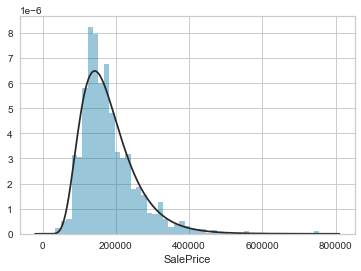

In [67]:
response = 'SalePrice'
sns.distplot(df_raw[response], kde=False, fit=stats.lognorm);


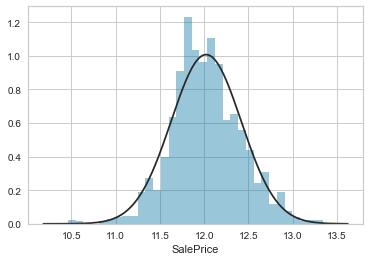

In [68]:
sns.distplot(np.log1p(df_raw.loc[df_raw['GrLivArea']<4000][response]), kde=False, fit=stats.norm);


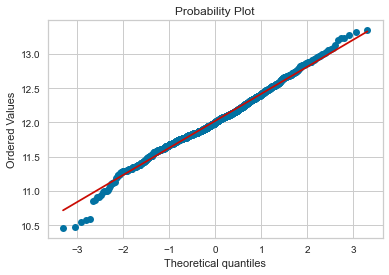

In [69]:
res = stats.probplot(np.log1p(df_raw.loc[df_raw['GrLivArea']<4000][response]), plot=plt);

In [70]:
widget_cats = []
widget_nums = []

for col in df_raw.columns:
    if col == response:
        continue
    if df_raw[col].dtype == np.dtype('O'):
        widget_cats.append(col)
    elif len(df_raw[col].value_counts()) <= 25:
        widget_cats.append(col)
    else:
        widget_nums.append(col)
        
widget_cats.sort()        
print(widget_cats)
print()
widget_nums.sort()
print(widget_nums)


['3SsnPorch', 'Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation', 'FullBath', 'Functional', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenAbvGr', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold', 'Neighborhood', 'OverallCond', 'OverallQual', 'PavedDrive', 'PoolArea', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'TotRmsAbvGrd', 'Utilities', 'YrSold']

['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'EnclosedPorch', 'GarageArea', 'GarageYrBlt', 'GrLivArea', 'Id', 'LotArea', 'LotFrontage', 'MasVnrArea', 

Dropdown(description='Variable:', options=('1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'E…

Dropdown(description='Color by:', index=47, options=('3SsnPorch', 'Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCo…

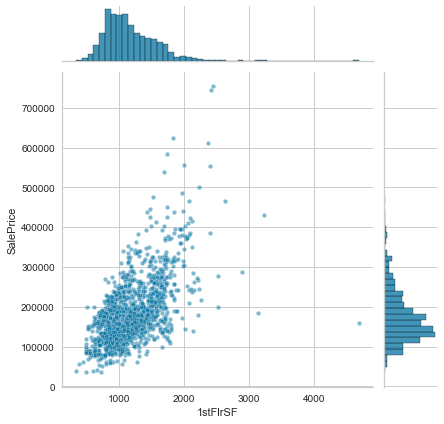

In [71]:
# interactive widget for continuous variables
df = df_raw
def on_value_change1(change):
    do_refresh(change['new'], gColor)

def on_value_change2(change):
    do_refresh(gVar, change['new'])

def do_refresh(var=widget_nums[0], colorby="Neighborhood"):

    global gVar
    gVar = var
    global gColor
    gColor = colorby
    
    clear_output()
    dropdown1 = widgets.Dropdown(
        options=widget_nums,
        value=var,
        description='Variable:',
        disabled=False,)
    display(dropdown1)

    dropdown1.observe(on_value_change1, names='value')

    dropdown2 = widgets.Dropdown(
        options=widget_cats,
        value=colorby,
        description='Color by:',
        disabled=False,)
    display(dropdown2)
    dropdown2.observe(on_value_change2, names='value')
    
    z = df.loc[~df[response].isna()]

    norm = matplotlib.colors.Normalize(vmin=0, vmax=21, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Dark2)
    
    colordict = {k: i for i, k in enumerate(z[colorby].unique())}
    z["color"] = z[colorby].apply(lambda x: matplotlib.colors.to_hex(mapper.to_rgba(colordict[x])))
    # print(z)
    sns.jointplot(var, 
                  response, 
                  data=z, 
                  alpha=0.5, 
                  s=20, 
                  # this stopped working on upgrade, need to troubleshoot
                  # joint_kws={"color": z["color"]}
                 )

do_refresh()


Dropdown(description='Cat:', options=('3SsnPorch', 'Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCond', 'BsmtExpos…

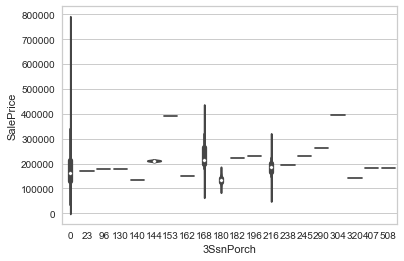

In [72]:
# interactive widget for categorical variables

def on_value_change3(change):
    do_refresh3(change['new'])

def do_refresh3(var=widget_cats[0]):

    clear_output()
    dropdown3 = widgets.Dropdown(
        options=widget_cats,
        value=var,
        description='Cat:',
        disabled=False,)
    display(dropdown3)
    dropdown3.observe(on_value_change3, names='value')
    
    z = df.loc[~df[response].isna()]

    sns.violinplot(x=var, y=response, data=z)    

do_refresh3()
    

In [73]:
# import test data
datafile = datadir + "test.csv"
df_test = pd.read_csv(datafile)
df_test[response]=np.nan
df_test.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,NaN
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,NaN
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,NaN
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,NaN
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal,NaN


In [74]:
# concatenate train and test for feature engineering across both
df_raw=pd.concat((df_raw, df_test)).set_index('Id')
print(df_raw.shape)


(2919, 80)


## 2. Scrub

In [75]:
df_raw.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

Per docs
23 nominal, 23 ordinal, 14 discrete, and 20 continuous variables 

Nominal (categorical)
- MS SubClass
- MS Zoning
- Street
- Alley
- Land Contour
- Lot Config
- Neighborhood
- Condition 1
- Condition 2
- Bldg Type
- House Style
- Roof Style 
- Roof Matl
- Exterior 1
- Exterior 2
- Mas Vnr Type
- Foundation
- Heating
- Central Air
- Garage Type
- Misc Feature
- Sale Type
- Sale Condition

Ordinal (categorical but map to numerical, like Po/Fa/TA/Gd/Ex)
- Lot Shape
- Utilities
- Land Slope
- Overall Qual
- Overall Cond
- Exter Qual
- Exter Cond
- Bsmt Qual
- Bsmt Cond
- Bsmt Exposure
- BsmtFin Type 1
- BsmtFinType 2
- HeatingQC
- Electrical
- KitchenQual
- Functional
- FireplaceQu
- Garage Finish 
- Garage Qual
- Garage Cond
- Paved Drive
- Pool QC
- Fence

Discrete (int)
- Year Built
- Year Remod/Add
- Bsmt Full Bath
- Bsmt Half Bath
- Full Bath
- Half Bath
- Bedroom
- Kitchen
- TotRmsAbvGrd
- Fireplaces
- Garage Yr Blt 
- Garage Cars
- Mo Sold
- Yr Sold

Continuous (float)
- Lot Frontage
- Lot Area
- Mas Vnr Area
- BsmtFin SF 1
- BsmtFin SF 2
- Bsmt Unf SF
- Total Bsmt SF
- 1st Flr SF
- 2nd Flr SF
- Low Qual Fin SF
- Gr Liv Area
- Garage Area
- Wood Deck SF
- Open Porch SF
- Enclosed Porch
- 3-Ssn Porch
- Screen Porch
- Pool Area
- Misc Val

Response
- SalePrice


In [76]:
categorical = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 'LotConfig', 
               'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
               'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
               'Foundation', 'Heating', 'CentralAir', 'GarageType', 'MiscFeature', 
               'SaleType', 'SaleCondition']

ordinal = ['LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 
           'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
           'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'Electrical', 'KitchenQual', 
           'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond',
           'PavedDrive', 'PoolQC', 'Fence',]

numerical = ['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 
             'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 
             'Fireplaces', 'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold', 
             
             'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',  'BsmtFinSF2', 
             'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
             'GrLivArea', 'GarageArea','WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
             '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']

response='SalePrice'

print("raw data shape", df_raw.shape)
print("categorical", len(categorical))
print("ordinal", len(ordinal))
print("numerical", len(numerical))
df_raw = df_raw[categorical + ordinal + numerical]
print(df_raw.shape)


raw data shape (2919, 80)
categorical 23
ordinal 23
numerical 34
(2919, 80)


In [77]:
df_raw.head()


,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,GarageType,MiscFeature,SaleType,SaleCondition,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,Electrical,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,YearBuilt,YearRemodAdd,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,MoSold,YrSold,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,Pave,NaN,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,Attchd,NaN,WD,Normal,Reg,AllPub,Gtl,7,5,Gd,TA,Gd,TA,No,GLQ,Unf,Ex,SBrkr,Gd,Typ,NaN,RFn,TA,TA,Y,NaN,NaN,2003,2003,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,2,2008,65.0,8450,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,548.0,0,61,0,0,0,0,0,208500.0
2,20,RL,Pave,NaN,Lvl,FR2,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,CBlock,GasA,Y,Attchd,NaN,WD,Normal,Reg,AllPub,Gtl,6,8,TA,TA,Gd,TA,Gd,ALQ,Unf,Ex,SBrkr,TA,Typ,TA,RFn,TA,TA,Y,NaN,NaN,1976,1976,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,5,2007,80.0,9600,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,460.0,298,0,0,0,0,0,0,181500.0
3,60,RL,Pave,NaN,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,Attchd,NaN,WD,Normal,IR1,AllPub,Gtl,7,5,Gd,TA,Gd,TA,Mn,GLQ,Unf,Ex,SBrkr,Gd,Typ,TA,RFn,TA,TA,Y,NaN,NaN,2001,2002,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,9,2008,68.0,11250,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,608.0,0,42,0,0,0,0,0,223500.0
4,70,RL,Pave,NaN,Lvl,Corner,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,BrkTil,GasA,Y,Detchd,NaN,WD,Abnorml,IR1,AllPub,Gtl,7,5,TA,TA,TA,Gd,No,ALQ,Unf,Gd,SBrkr,Gd,Typ,Gd,Unf,TA,TA,Y,NaN,NaN,1915,1970,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,2,2006,60.0,9550,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,642.0,0,35,272,0,0,0,0,140000.0
5,60,RL,Pave,NaN,Lvl,FR2,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,Attchd,NaN,WD,Normal,IR1,AllPub,Gtl,8,5,Gd,TA,Gd,TA,Av,GLQ,Unf,Ex,SBrkr,Gd,Typ,TA,RFn,TA,TA,Y,NaN,NaN,2000,2000,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,12,2008,84.0,14260,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,836.0,192,84,0,0,0,0,0,250000.0


In [78]:
# remove sf > 4000 per docs, http://jse.amstat.org/v19n3/decock.pdf
df= df_raw.loc[~((df_raw['GrLivArea'] > 4000) & (~df_raw[response].isna()))]


#### Map categorical to int

In [79]:
# map all the columns listed as ordinal to int
# per http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

# map these 9 quality label cols to int

qdict = {
    'Po' : 0,
    'Fa' : 1,
    'TA' : 2,
    'Gd' : 3,
    'Ex' : 4,
    np.nan : 2
}

qcols = ['ExterQual',
         'ExterCond',
         'BsmtQual',
         'BsmtCond',
         'HeatingQC',
         'KitchenQual',
         'GarageQual',
         'GarageCond',
         'FireplaceQu'         
        ]

# these values are very rare (<=5), roll poor->fair, excellent->good
df.loc[df['ExterCond']=='Po', 'ExterCond'] = 'Fa'
df.loc[df['BsmtCond']=='Po', 'BsmtCond'] = 'Fa'
df.loc[df['HeatingQC']=='Po', 'HeatingQC'] = 'Fa'
df.loc[df['GarageQual']=='Po', 'GarageQual'] = 'Fa'
df.loc[df['GarageQual']=='Ex', 'GarageQual'] = 'Gd'
df.loc[df['GarageCond']=='Ex', 'GarageCond'] = 'Gd'

for col in qcols:
    print(col)
    print(df[col].value_counts())
    df.loc[:, col] = df[col].apply(lambda q: qdict[q])
    df.loc[:, col] = df[col].astype(int)
    print(df[col].value_counts())


ExterQual
TA    1798
Gd     978
Ex     104
Fa      35
Name: ExterQual, dtype: int64
2    1798
3     978
4     104
1      35
Name: ExterQual, dtype: int64
ExterCond
TA    2534
Gd     299
Fa      70
Ex      12
Name: ExterCond, dtype: int64
2    2534
3     299
1      70
4      12
Name: ExterCond, dtype: int64
BsmtQual
TA    1283
Gd    1209
Ex     254
Fa      88
Name: BsmtQual, dtype: int64
2    1364
3    1209
4     254
1      88
Name: BsmtQual, dtype: int64
BsmtCond
TA    2602
Gd     122
Fa     109
Name: BsmtCond, dtype: int64
2    2684
3     122
1     109
Name: BsmtCond, dtype: int64
HeatingQC
Ex    1489
TA     857
Gd     474
Fa      95
Name: HeatingQC, dtype: int64
4    1489
2     857
3     474
1      95
Name: HeatingQC, dtype: int64
KitchenQual
TA    1492
Gd    1151
Ex     201
Fa      70
Name: KitchenQual, dtype: int64
2    1493
3    1151
4     201
1      70
Name: KitchenQual, dtype: int64
GarageQual
TA    2600
Fa     129
Gd      27
Name: GarageQual, dtype: int64
2    2759
1     129
3 

In [80]:
print(df['LandSlope'].value_counts())

slope_dict = {
    'Gtl': 0,
    'Mod' : 1,
    'Sev' : 2,
}

df['LandSlope'] = df['LandSlope'].apply(lambda q: slope_dict[q])

print(df['LandSlope'].value_counts())


Gtl    2774
Mod     125
Sev      16
Name: LandSlope, dtype: int64
0    2774
1     125
2      16
Name: LandSlope, dtype: int64


In [81]:
print(df['GarageFinish'].value_counts())

garagefinish_dict = {
    np.nan : 0,
    'Unf': 1,
    'RFn' : 2,
    'Fin' : 3,
}
df['GarageFinish'] = df['GarageFinish'].apply(lambda q: garagefinish_dict[q])

print(df['GarageFinish'].value_counts())


Unf    1230
RFn     811
Fin     715
Name: GarageFinish, dtype: int64
1    1230
2     811
3     715
0     159
Name: GarageFinish, dtype: int64


In [82]:
#        Gd	Good Exposure
#        Av	Average Exposure (split levels or foyers typically score average or above)	
#        Mn	Mimimum Exposure
#        No	No Exposure
#        NA	No Basement

print(df['BsmtExposure'].value_counts())

BsmtExposure_dict = {
    np.nan : 0,
    'No' : 1,
    'Mn' : 2, 
    'Av' : 3, 
    'Gd' : 4
}
df['BsmtExposure'] = df['BsmtExposure'].apply(lambda q: BsmtExposure_dict[q])

print(df['BsmtExposure'].value_counts())


No    1904
Av     417
Gd     273
Mn     239
Name: BsmtExposure, dtype: int64
1    1904
3     417
4     273
2     239
0      82
Name: BsmtExposure, dtype: int64


In [83]:
#        Typ	Typical Functionality
#        Min1	Minor Deductions 1
#        Min2	Minor Deductions 2
#        Mod	Moderate Deductions
#        Maj1	Major Deductions 1
#        Maj2	Major Deductions 2
#        Sev	Severely Damaged
#        Sal	Salvage only

print(df['Functional'].value_counts())

functional_dict = {
    np.nan:  4,
    'Sev':   0,
    'Maj1':  0,
    'Maj2':  0,
    'Mod':   1,
    'Min2':  2,
    'Min1':  3,
    'Typ' :  4,
}
df['Functional'] = df['Functional'].apply(lambda q: functional_dict[q])

print(df['Functional'].value_counts())


Typ     2713
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64
4    2715
2      70
3      65
1      35
0      30
Name: Functional, dtype: int64


In [84]:
#        NA	No Basement
#        Unf	Unfinshed
#        LwQ	Low Quality
#        BLQ	Below Average Living Quarters	
#        Rec	Average Rec Room
#        ALQ	Average Living Quarters
#       GLQ	Good Living Quarters

print(df['BsmtFinType1'].value_counts())

bsmt_fintype_dict = {
    np.nan : 0,
    'NA' : 0,
    'Unf' : 1,
    'LwQ' : 2,
    'BLQ' : 3,
    'Rec' : 4,
    'ALQ' : 5,
    'GLQ' : 6
}

df['BsmtFinType1'] = df['BsmtFinType1'].apply(lambda q: bsmt_fintype_dict[q])

print(df['BsmtFinType1'].value_counts())

print(df['BsmtFinType2'].value_counts())
df['BsmtFinType2'] = df['BsmtFinType2'].apply(lambda q: bsmt_fintype_dict[q])
print(df['BsmtFinType2'].value_counts())


Unf    851
GLQ    845
ALQ    429
Rec    288
BLQ    269
LwQ    154
Name: BsmtFinType1, dtype: int64
1    851
6    845
5    429
4    288
3    269
2    154
0     79
Name: BsmtFinType1, dtype: int64
Unf    2489
Rec     105
LwQ      87
BLQ      68
ALQ      52
GLQ      34
Name: BsmtFinType2, dtype: int64
1    2489
4     105
2      87
0      80
3      68
5      52
6      34
Name: BsmtFinType2, dtype: int64


In [85]:
#        Reg	Regular	
#        IR1	Slightly irregular
#        IR2	Moderately Irregular
#        IR3	Irregular
print(df['LotShape'].value_counts())
 
lotshape_dict = {
    np.nan : 0,
    'Reg' : 0,
    'IR1' : 1,
    'IR2' : 2,
    'IR3' : 2,
}    

df['LotShape'] = df['LotShape'].apply(lambda q: lotshape_dict[q])

print(df['LotShape'].value_counts())


Reg    1859
IR1     965
IR2      76
IR3      15
Name: LotShape, dtype: int64
0    1859
1     965
2      91
Name: LotShape, dtype: int64


In [86]:
#        SBrkr	Standard Circuit Breakers & Romex
#        FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
#        FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
#        FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
#        Mix	Mixed

print(df['Electrical'].value_counts())
 
elec_dict = {
    np.nan : 0,
    'Mix' : 0,
    'FuseP' : 0,
    'FuseF' : 2,
    'FuseA' : 3,
    'SBrkr' : 4,
}    

df['Electrical'] = df['Electrical'].apply(lambda q: elec_dict[q])

print(df['Electrical'].value_counts())


SBrkr    2667
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64
4    2667
3     188
2      50
0      10
Name: Electrical, dtype: int64


In [87]:
# Paved Drive (Ordinal): Paved driveway

#        Y	Paved 
#        P	Partial Pavement
#        N	Dirt/Gravel
        
print(df['PavedDrive'].value_counts())
 
pave_dict = {
    'N' : 0,
    'P' : 1,
    'Y' : 2,
}    

df['PavedDrive'] = df['PavedDrive'].apply(lambda q: pave_dict[q])

print(df['PavedDrive'].value_counts())


Y    2637
N     216
P      62
Name: PavedDrive, dtype: int64
2    2637
0     216
1      62
Name: PavedDrive, dtype: int64


In [88]:
# Fence (Ordinal): Fence quality
#        GdPrv	Good Privacy
#        MnPrv	Minimum Privacy
#        GdWo	Good Wood
#        MnWw	Minimum Wood/Wire
#        NA	No Fence

print(df['Fence'].value_counts())

fence_dict = {
    np.nan : 0,
    'MnWw' : 1,
    'GdWo' : 2,
    'MnPrv' : 3,
    'GdPrv' : 4,
}

df['Fence'] = df['Fence'].apply(lambda q: fence_dict[q])

print(df['Fence'].value_counts())


MnPrv    328
GdPrv    118
GdWo     112
MnWw      12
Name: Fence, dtype: int64
0    2345
3     328
4     118
2     112
1      12
Name: Fence, dtype: int64


In [89]:
# Map these categorical vars 

#        1Story	One story
#        SFoyer	Split Foyer
#        SLvl	Split Level
#     1.5Fin	One and one-half story: 2nd level finished
#        1.5Unf	One and one-half story: 2nd level unfinished
#        2Story	Two story
#        2.5Fin	Two and one-half story: 2nd level finished
#        2.5Unf	Two and one-half story: 2nd level unfinished

print(df['HouseStyle'].value_counts())

story_dict = {
    '1Story' : 0,
    'SFoyer' : 1,
    'SLvl'   : 2,
    '1.5Unf' : 3,
    '1.5Fin' : 4,
    '2Story' : 5,
    '2.5Unf' : 6,
    '2.5Fin' : 7    
}

df['HouseStyle'] = df['HouseStyle'].apply(lambda q: story_dict[q])

print(df['HouseStyle'].value_counts())


1Story    1471
2Story     868
1.5Fin     314
SLvl       128
SFoyer      83
2.5Unf      24
1.5Unf      19
2.5Fin       8
Name: HouseStyle, dtype: int64
0    1471
5     868
4     314
2     128
1      83
6      24
3      19
7       8
Name: HouseStyle, dtype: int64


In [90]:
print(df['CentralAir'].value_counts())
df['CentralAir'] = df['CentralAir'] == 'Y' 
df['CentralAir'] = df['CentralAir'].astype(int)
print(df['CentralAir'].value_counts())


Y    2719
N     196
Name: CentralAir, dtype: int64
1    2719
0     196
Name: CentralAir, dtype: int64


In [91]:
df.head()

,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,GarageType,MiscFeature,SaleType,SaleCondition,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,Electrical,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,YearBuilt,YearRemodAdd,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,MoSold,YrSold,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,Pave,NaN,Lvl,Inside,CollgCr,Norm,Norm,1Fam,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,1,Attchd,NaN,WD,Normal,0,AllPub,0,7,5,3,2,3,2,1,6,1,4,4,3,4,2,2,2,2,2,NaN,0,2003,2003,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,2,2008,65.0,8450,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,548.0,0,61,0,0,0,0,0,208500.0
2,20,RL,Pave,NaN,Lvl,FR2,Veenker,Feedr,Norm,1Fam,0,Gable,CompShg,MetalSd,MetalSd,None,CBlock,GasA,1,Attchd,NaN,WD,Normal,0,AllPub,0,6,8,2,2,3,2,4,5,1,4,4,2,4,2,2,2,2,2,NaN,0,1976,1976,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,5,2007,80.0,9600,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,460.0,298,0,0,0,0,0,0,181500.0
3,60,RL,Pave,NaN,Lvl,Inside,CollgCr,Norm,Norm,1Fam,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,1,Attchd,NaN,WD,Normal,1,AllPub,0,7,5,3,2,3,2,2,6,1,4,4,3,4,2,2,2,2,2,NaN,0,2001,2002,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,9,2008,68.0,11250,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,608.0,0,42,0,0,0,0,0,223500.0
4,70,RL,Pave,NaN,Lvl,Corner,Crawfor,Norm,Norm,1Fam,5,Gable,CompShg,Wd Sdng,Wd Shng,None,BrkTil,GasA,1,Detchd,NaN,WD,Abnorml,1,AllPub,0,7,5,2,2,2,3,1,5,1,3,4,3,4,3,1,2,2,2,NaN,0,1915,1970,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,2,2006,60.0,9550,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,642.0,0,35,272,0,0,0,0,140000.0
5,60,RL,Pave,NaN,Lvl,FR2,NoRidge,Norm,Norm,1Fam,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,1,Attchd,NaN,WD,Normal,1,AllPub,0,8,5,3,2,3,2,3,6,1,4,4,3,4,2,2,2,2,2,NaN,0,2000,2000,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,12,2008,84.0,14260,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,836.0,192,84,0,0,0,0,0,250000.0


#### Impute / fill NAs

In [92]:
# For garage, basement, bathroom/half, assume if missing then this feature is not present

zlist = ['MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
         '2ndFlrSF','LowQualFinSF',
         'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
         'Fireplaces','GarageCars','GarageArea',
         'WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch',
         'PoolArea','MiscVal']
        
for col in zlist:
    print(col)
    df[col].fillna(0, inplace=True)
for col in ['GarageYrBlt']:
    print(col)
    df[col].fillna(df['YearBuilt'], inplace=True)
    df[col]=df[col].astype(int)
for col in ['GarageType']:
    print(col)
    df[col].fillna('None', inplace=True)

df.loc[:, 'BsmtFullBath']=df['BsmtFullBath'].astype(int)
df.loc[:, 'BsmtHalfBath']=df['BsmtHalfBath'].astype(int)
df.loc[:, 'GarageCars']=df['GarageCars'].astype(int)


MasVnrArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
2ndFlrSF
LowQualFinSF
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
Fireplaces
GarageCars
GarageArea
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
MiscVal
GarageYrBlt
GarageType


In [93]:
for col in df.columns:
    print(col)
    print (df[col].value_counts())
    print()
    

MSSubClass
20     1079
60      571
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

MSZoning
RL         2261
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

Street
Pave    2903
Grvl      12
Name: Street, dtype: int64

Alley
Grvl    120
Pave     78
Name: Alley, dtype: int64

LandContour
Lvl    2620
HLS     120
Bnk     115
Low      60
Name: LandContour, dtype: int64

LotConfig
Inside     2132
Corner      508
CulDSac     176
FR2          85
FR3          14
Name: LotConfig, dtype: int64

Neighborhood
NAmes      443
CollgCr    267
OldTown    239
Edwards    192
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     69
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
B

864     41
1092    26
1040    25
1456    20
1200    18
        ..
2414     1
2402     1
2400     1
2398     1
2049     1
Name: GrLivArea, Length: 1288, dtype: int64

GarageArea
0.0      158
576.0     97
440.0     96
240.0     69
484.0     68
        ... 
963.0      1
263.0      1
962.0      1
475.0      1
803.0      1
Name: GarageArea, Length: 600, dtype: int64

WoodDeckSF
0      1523
100      74
192      70
144      61
168      56
       ... 
89        1
95        1
97        1
99        1
857       1
Name: WoodDeckSF, Length: 379, dtype: int64

OpenPorchSF
0      1298
36       52
48       51
40       44
32       38
       ... 
372       1
368       1
364       1
324       1
282       1
Name: OpenPorchSF, Length: 250, dtype: int64

EnclosedPorch
0      2456
112      22
96       13
144      11
192      10
       ... 
334       1
330       1
324       1
318       1
238       1
Name: EnclosedPorch, Length: 183, dtype: int64

3SsnPorch
0      2878
153       3
168       3
144       2
180  

In [94]:
df.loc[df['MSSubClass'] == 150]

,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,GarageType,MiscFeature,SaleType,SaleCondition,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,Electrical,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,YearBuilt,YearRemodAdd,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,MoSold,YrSold,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2819,150,RL,Pave,NaN,HLS,Inside,ClearCr,Norm,Norm,Twnhs,4,Gable,CompShg,VinylSd,VinylSd,None,PConc,GasA,1,Basment,NaN,WD,Normal,0,AllPub,0,7,5,3,2,3,2,2,6,1,2,4,3,4,2,3,3,2,2,NaN,0,1980,1981,1,0,2,1,2,1,7,0,1980,1,4,2006,NaN,1700,0.0,397.0,0.0,33.0,430.0,880,680,140,1700,450.0,188,36,0,0,200,0,0,NaN


In [95]:
display(df.groupby(['MSSubClass']).mean()[[response]].reset_index().sort_values(response))
display(df.groupby(['MSSubClass']).count()[[response]].reset_index().sort_values(response))

,MSSubClass,SalePrice
1,30,95829.724638
14,180,102300.000000
3,45,108591.666667
15,190,129613.333333
10,90,133541.076923
13,160,138647.380952
4,50,143302.972222
9,85,147810.000000
2,40,156125.000000
6,70,166772.416667


,MSSubClass,SalePrice
12,150,0
2,40,4
14,180,10
3,45,12
7,75,16
9,85,20
15,190,30
10,90,52
8,80,58
6,70,60


In [96]:
#        020	1-STORY 1946 & NEWER ALL STYLES
#        030	1-STORY 1945 & OLDER
#        040	1-STORY W/FINISHED ATTIC ALL AGES
#        045	1-1/2 STORY - UNFINISHED ALL AGES
#        050	1-1/2 STORY FINISHED ALL AGES
#        060	2-STORY 1946 & NEWER
#        070	2-STORY 1945 & OLDER
#        075	2-1/2 STORY ALL AGES
#        080	SPLIT OR MULTI-LEVEL
#        085	SPLIT FOYER
#        090	DUPLEX - ALL STYLES AND AGES
#        120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
#        150	1-1/2 STORY PUD - ALL AGES
#        160	2-STORY PUD - 1946 & NEWER
#        180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
#        190	2 FAMILY CONVERSION - ALL STYLES AND AGES

print(df['MSSubClass'].value_counts())

MSSubClass_dict = {
    40 : 70,
    45 : 45,
    150 : 160,
    180 : 30,
    20 : 20,
    60 : 60,
    50 : 50,
    120 : 120,
    30 : 30,
    160 : 160,
    70 : 70,
    80 : 80,
    90 : 90,
    190 : 190,
    85 : 85,
    75 : 75,
}

df['MSSubClass'] = df['MSSubClass'].apply(lambda q: MSSubClass_dict[q])

print(df['MSSubClass'].value_counts())


20     1079
60      571
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64
20     1079
60      571
50      287
120     182
30      156
70      134
160     129
80      118
90      109
190      61
85       48
75       23
45       18
Name: MSSubClass, dtype: int64


In [97]:
# fill missing MSZoning using most popular value by subclass
df.loc[:, 'MSZoning'] = df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

# fill missing LotFrontage using median value by Neighborhood
# could also impute using LotArea
df.loc[:, 'LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))


In [98]:
# impute categorical strings

oimpute = {'MSZoning' : 'RL',
           'MasVnrType' : 'None',
           'Utilities': 'AllPub',
           'Exterior1st': 'VinylSd',
           'Exterior2nd': 'VinylSd',
           'BsmtExposure' : 'No',
           'BsmtFinType1': 'Unf',
           'BsmtFinType2': 'Unf',
           'Electrical' : 'SBrkr',
           'GarageType'  : 'Attchd',
           'GarageFinish' : 'Unf',
           'GarageCond' : 'TA',
           'Functional' : 'Typ',
           'SaleType': 'WD',
           'Alley': 'None',
           'FireplaceQu': 'TA',
           'PoolQC' : 'None',
           'Fence': 'Other',
           'MiscFeature': 'Other',
          }

def impute_strings(features, ocols, groupby):
    
    for col in ocols:
        nmissing = features[col].isna().sum()
        if nmissing:
            print(col, 'missing', features[col].isna().sum())
            print(features[col].value_counts())
            if groupby:
                features[col] = features.groupby(groupby)[col].transform(lambda x: x.fillna(x.mode()[0]))
            features[col].fillna(oimpute[col], inplace=True)
    return features

ocols = list([df.columns[i] for i,t in enumerate(list(df.dtypes)) if t == np.dtype('O')])

df = impute_strings(df, ocols, None)


Alley missing 2717
Grvl    120
Pave     78
Name: Alley, dtype: int64
Exterior1st missing 1
VinylSd    1025
MetalSd     450
HdBoard     441
Wd Sdng     410
Plywood     221
CemntBd     125
BrkFace      87
WdShing      56
AsbShng      44
Stucco       42
BrkComm       6
Stone         2
CBlock        2
AsphShn       2
ImStucc       1
Name: Exterior1st, dtype: int64
Exterior2nd missing 1
VinylSd    1014
MetalSd     447
HdBoard     405
Wd Sdng     391
Plywood     270
CmentBd     125
Wd Shng      81
BrkFace      47
Stucco       46
AsbShng      38
Brk Cmn      22
ImStucc      14
Stone         6
AsphShn       4
CBlock        3
Other         1
Name: Exterior2nd, dtype: int64
MasVnrType missing 24
None       1741
BrkFace     878
Stone       247
BrkCmn       25
Name: MasVnrType, dtype: int64
MiscFeature missing 2810
Shed    95
Gar2     5
Othr     4
TenC     1
Name: MiscFeature, dtype: int64
SaleType missing 1
WD       2523
New       237
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw 

In [99]:
# impute mean for missing floats - mean by neighborhood

def impute_floats(features, fcols, groupby='Neighborhood', response=response):

    for col in fcols:
        if col == response:
            continue
        nmissing = features[col].isna().sum()
        if nmissing:
            print(col)
            print('missing', features[col].isna().sum())
            display(df.loc[df[col].isna()])
            if groupby:
                features.loc[:,col] = features.groupby(groupby)[col].transform(lambda x: x.fillna(x.mean()))
            else:
                features.loc[:,col] = features[col].mean()
                
    return features

# set this to 0 since MasVnrType is always 'None' when MasVnrArea is nan
df.loc[df['MasVnrArea'].isna(), 'MasVnrArea'] = 0

# set this to 0 since these do not seem to have a basement
df.loc[df['BsmtFinSF1'].isna(), 'BsmtFinSF1'] = 0
df.loc[df['BsmtFinSF2'].isna(), 'BsmtFinSF2'] = 0
df.loc[df['BsmtUnfSF'].isna(), 'BsmtUnfSF'] = 0
df.loc[df['TotalBsmtSF'].isna(), 'TotalBsmtSF'] = 0

fcols = list([df.columns[i] for i,t in enumerate(list(df.dtypes)) if t in numeric_dtypes])

df = impute_floats(df, fcols, 'Neighborhood')


In [100]:
# map all remaining categorical variables to ints by grouping and sorting by mean SalePrice
# i.e. categorical var with lowest average saleprice maps to 0, next lowest is 1, etc.
# numeric values potentially allow interaction features

labelencoded = []

def myLabelEncoder(df, column, target, order_only=True, verbose=True):
    
    temp_df= df.loc[~df[target].isna()][[column, target]] \
        .groupby(column) \
        .agg(np.mean) \
        .sort_values(target) \
        .reset_index()
    
    if order_only == True:
        mapdict = dict(zip(temp_df[column], temp_df.index))
    else:
        mapdict = dict(zip(temp_df[column], temp_df[target]))

    mapdict[np.nan] = np.nan

    if verbose:
        print(mapdict)
    
    return df[column].apply(lambda q: mapdict[q])

for col in df.columns:
    if df[col].dtype in numeric_dtypes:
        continue
    else:
        df[col] = myLabelEncoder(df, col, response)
        labelencoded.append(col)

{'C (all)': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4, nan: nan}
{'Grvl': 0, 'Pave': 1, nan: nan}
{'Grvl': 0, 'Pave': 1, 'None': 2, nan: nan}
{'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3, nan: nan}
{'Inside': 0, 'Corner': 1, 'FR2': 2, 'FR3': 3, 'CulDSac': 4, nan: nan}
{'MeadowV': 0, 'IDOTRR': 1, 'BrDale': 2, 'BrkSide': 3, 'Edwards': 4, 'OldTown': 5, 'Sawyer': 6, 'Blueste': 7, 'SWISU': 8, 'NPkVill': 9, 'NAmes': 10, 'Mitchel': 11, 'SawyerW': 12, 'NWAmes': 13, 'Gilbert': 14, 'Blmngtn': 15, 'CollgCr': 16, 'Crawfor': 17, 'ClearCr': 18, 'Somerst': 19, 'Veenker': 20, 'Timber': 21, 'StoneBr': 22, 'NoRidge': 23, 'NridgHt': 24, nan: nan}
{'Artery': 0, 'RRAe': 1, 'Feedr': 2, 'Norm': 3, 'RRAn': 4, 'RRNe': 5, 'RRNn': 6, 'PosN': 7, 'PosA': 8, nan: nan}
{'RRNn': 0, 'Artery': 1, 'Feedr': 2, 'RRAn': 3, 'Norm': 4, 'RRAe': 5, 'PosA': 6, 'PosN': 7, nan: nan}
{'2fmCon': 0, 'Duplex': 1, 'Twnhs': 2, 'TwnhsE': 3, '1Fam': 4, nan: nan}
{'Gambrel': 0, 'Gable': 1, 'Mansard': 2, 'Flat': 3, 'Hip': 4, 'Shed': 5, nan: nan}
{'

#### Roll up rare categorical values

In [101]:
print(df['OverallQual'].value_counts())
df.loc[df['OverallQual'] == 1, 'OverallQual'] = 2
print(df['OverallQual'].value_counts())

print(df['OverallCond'].value_counts())
df.loc[df['OverallCond'] == 1, 'OverallCond'] = 2
print(df['OverallCond'].value_counts())


5     825
6     731
7     600
8     342
4     226
9     107
3      40
10     27
2      13
1       4
Name: OverallQual, dtype: int64
5     825
6     731
7     600
8     342
4     226
9     107
3      40
10     27
2      17
Name: OverallQual, dtype: int64
5    1642
6     530
7     390
8     144
4     101
3      50
9      41
2      10
1       7
Name: OverallCond, dtype: int64
5    1642
6     530
7     390
8     144
4     101
3      50
9      41
2      17
Name: OverallCond, dtype: int64


In [102]:
# roll up low cardinality categorical variables

def rollup_low_cardinality(features, threshold):
    """Rollup least frequent categorical features, up to total threshold observations rolled up"""
    for col in features.columns:
        # skip numerics
        if (features[col].dtype in numeric_dtypes):
            continue
        
        print(col)
        counts = features[col].value_counts()
        howmany=0
        vals = []
        for i, (val, c) in reversed(list(enumerate(zip(list(counts.index), list(counts))))):
            if howmany + c < threshold:
                print(val, c)
                howmany += c
                vals += [val]
            else:
                break
        if len(vals) > 1:
            print ('Rollup', vals)
            for v in vals:
                features.loc[features[col] == v, col] = 'Rollup'
        print()
    return features

def rollup_low_cardinality_int(df, preds, threshold):
    """Rollup least frequent ordered features
    if < threshold, roll into next higher
    if highest, roll into next lower
    """
    for col in preds:
        print(col)
        counts = df[col].value_counts()
        counts = df[col].value_counts().sort_index()
        print(counts)
        indexlist = list(counts.index)
        for i, val in enumerate(indexlist):
            if counts[val] < threshold:
                if val < len(indexlist)-1:
                    # not last
                    print(val, '=>', indexlist[i+1])
                    df.loc[df[col]==val, col] = indexlist[i+1]
                    # update counts so you don't roll up if now > thresh
                    counts[indexlist[i+1]] += counts[indexlist[i]]
                else:
                    print(val, '=>', indexlist[i-1])
                    df.loc[df[col]==val, col] = indexlist[i-1]
                    #no need to update since last

    return df

df = rollup_low_cardinality(df, 25)

intcats = ['LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType',
           'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation',
           'Heating','GarageType','SaleType','SaleCondition','LotShape','LandSlope',
           'ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','Electrical',
           'KitchenQual','GarageFinish','GarageQual','GarageCond','PavedDrive',
           'BsmtFullBath','HalfBath','KitchenAbvGr','Fireplaces',]

df = rollup_low_cardinality_int(df, intcats, 5)


LandContour
0     115
1    2620
2      60
3     120
Name: LandContour, dtype: int64
LotConfig
0    2132
1     508
2      85
3      14
4     176
Name: LotConfig, dtype: int64
Neighborhood
0      37
1      93
2      30
3     108
4     192
5     239
6     151
7      10
8      48
9      23
10    443
11    114
12    125
13    131
14    165
15     28
16    267
17    103
18     44
19    182
20     24
21     72
22     51
23     69
24    166
Name: Neighborhood, dtype: int64
Condition1
0      92
1      28
2     163
3    2509
4      50
5       6
6       9
7      38
8      20
Name: Condition1, dtype: int64
Condition2
0       2
1       5
2      13
3       1
4    2886
5       1
6       4
7       3
Name: Condition2, dtype: int64
0 => 1
3 => 4
5 => 6
7 => 6
BldgType
0      62
1     109
2      96
3     227
4    2421
Name: BldgType, dtype: int64
RoofStyle
0      22
1    2309
2      11
3      20
4     548
5       5
Name: RoofStyle, dtype: int64
RoofMatl
0       1
1    2874
2       1
3      23
4       9
5

#### Engineer

In [103]:
# Compute additional features

#df['MS SubClass']=df['MS SubClass'].astype(str)
df['TotalFinSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['1stFlrSF'] + df['2ndFlrSF']
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['BsmtFinSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2']
df['PorchSF'] = df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF']

df['BsmtFullBath'].fillna(0, inplace=True)
df.loc[df['BsmtFullBath'] > 2, 'BsmtFullBath'] = 2
df['BsmtHalfBath'].fillna(0, inplace=True)
df['TotalBath'] = df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath'] + df['FullBath'] + 0.5 * df['HalfBath']
df.loc[df['TotalBath'] >=4, 'TotalBath'] = 4
df['BsmtBath'] = df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
df.loc[df['BsmtBath'] >= 1, 'BsmtBath'] = 1

df['BsmtFullBath'] = df['BsmtFullBath'].astype(int)
df.drop(columns=['BsmtHalfBath'], inplace=True)

df['AvgBltRemod'] = (df['YearBuilt'] + df['YearRemodAdd']) / 2
df['AvgBltRemod'] = 2010 - df['AvgBltRemod'] 
df['YearBuilt'] = 2010 - df['YearBuilt'] 
df['PreWarYearBuilt'] = df['YearBuilt'].apply(lambda x: 68-x if x < 68 else 0) 
df['RecentYearBuilt'] = df['YearBuilt'].apply(lambda x: 12-x if x < 12 else 0) 
df['YearRemodAdd'] = 2010 - df['YearRemodAdd'] 
df['GarageYrBlt'] = 2010 - df['GarageYrBlt'] 

# cap and floor outliers
df.loc[df['KitchenAbvGr'] > 2, 'KitchenAbvGr'] = 2
df.loc[df['GarageCars'] >= 3, 'GarageCars'] = 3
df.loc[df['TotRmsAbvGrd'] <=3, 'TotRmsAbvGrd'] = 3
df.loc[df['BedroomAbvGr'] > 6, 'BedroomAbvGr'] = 6
df.loc[df['TotRmsAbvGrd'] > 12, 'TotRmsAbvGrd'] = 12
df.loc[df['Fireplaces'] >= 3, 'Fireplaces'] = 3

# fix 1 bad value
df.loc[df['GarageYrBlt'] < 0, 'GarageYrBlt'] = 0

# Booleans
df['haspool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df['has2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
#df['hasgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
#df['hasbsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df['hasfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# Ratios
df['LivAreaRatio'] = df['TotalSF'] / df['LotArea']
df['BedRatio'] = df['GrLivArea'] / df['BedroomAbvGr']
df.loc[df['BedRatio'] > 2500, 'BedRatio'] = 2500
df['GarageRatio']  = df['GarageCars'] / df['BedroomAbvGr']
df.loc[df['GarageRatio'] > 5, 'GarageRatio'] = 5
df['BathRatio'] = df['TotalBath'] /  df['BedroomAbvGr']
df.loc[df['BathRatio'] > 5, 'BathRatio'] = 5
df['LotRatio'] = df['LotArea'] / df['LotFrontage']
df.loc[df['LotRatio'] > 500, 'LotRatio'] = 500
df['FireBathRatio'] = df['Fireplaces'] / df['TotalBath']
df.loc[df['FireBathRatio'] > 1.5, 'FireBathRatio'] = 1.5
# merge unpaved, partial paved
df.loc[df['PavedDrive']==1,'PavedDrive'] = 0

# df['OverallQualRatio'] = (df['OverallQual'] + 1) / (df['OverallCond'] + 1)
# df['ExterQualRatio'] = (df['ExterQual'] + 1) / (df['ExterCond'] + 1)
# df['BsmtQualRatio'] = (df['BsmtQual'] + 1) / (df['BsmtCond']   + 1)
# df['GarageQualRatio'] = (df['GarageQual'] + 1) / (df['GarageCond']   + 1)

# df['Gr Liv Area x Overall Qual'] = df['Gr Liv Area'] * df['Overall Qual']

# interaction features, have residual correlation and also look reasonable
df['TotalSF x OverallQual x OverallCond'] = df['TotalSF'] * df['OverallQual'] * df['OverallCond']
df['TotalSF x OverallQual x Functional'] = df['TotalSF'] * df['OverallQual'] * df['Functional']
df['AvgBltRemod x Functional x TotalFinSF'] = df['AvgBltRemod'] * df['Functional'] * df['TotalFinSF']

df['TotalSF x OverallQual'] = df['TotalSF'] * df['OverallQual']
df['TotalSF x OverallCond'] = df['TotalSF'] * df['OverallCond']
df['TotalFinSF x Functional'] = df['Functional'] * df['TotalFinSF']
#df['OverallQual x OverallCond'] = df['OverallQual'] * df['OverallCond']
df['Functional x OverallQual'] = df['Functional'] * df['OverallQual']
df['AvgBltRemod x OverallCond'] = df['AvgBltRemod'] * df['OverallCond']
df['AvgBltRemod x TotalFinSF'] = df['AvgBltRemod'] * df['TotalFinSF']
#df['YearBuilt x OverallCond'] = df['YearBuilt'] * df['OverallCond']
df['OverallCond x AvgBltRemod'] = df['OverallCond'] * df['AvgBltRemod']

df['BsmtFinSF x BsmtQual'] = df['BsmtFinSF'] * df['BsmtQual']
df['BsmtFinSF x BsmtBath'] = df['BsmtFinSF'] * df['BsmtBath']
df['KitchenAbvGr x KitchenQual'] = df['KitchenAbvGr'] * df['KitchenQual']
df['GarageCars x GarageYrBlt'] = df['GarageCars'] * df['GarageYrBlt']

#df['ExterQual x ExterCond x Exterior1st'] = df['ExterQual'] * df['ExterCond'] * df['Exterior1st']
#df['BsmtQual x BsmtCond x BsmtFinSF'] = df['BsmtQual'] * df['BsmtCond'] * df['BsmtFinSF']
df['GarageQual x GarageCond x GarageCars'] = df['GarageQual'] * df['GarageCond'] * df['GarageCars']

df['HeatingQC x Heating'] = df['HeatingQC'] * df['Heating']
df['FireplaceQu x Fireplaces'] = df['FireplaceQu'] * df['Fireplaces']
         

In [104]:
# add sequential month index to capture any trend
def add_trend(features, datecols=['YrSold', 'MoSold']):
    yearmo = features[datecols]

    yearmo = yearmo.sort_values(datecols) \
        .groupby(datecols) \
        .first()\
        .reset_index() \
        .reset_index() \
        .rename(columns={'index': 'monthnum'})

    display(yearmo.head(5))
    display(yearmo.tail(5))

    print(features.shape)
    # merge messes up the order, so reset index, merge, apply index, sort index
    features.reset_index(inplace=True)
    
    features = features.merge(yearmo, on=datecols)
    features.set_index('Id', inplace=True)
    features.sort_index(inplace=True)
    print(features.shape)
    return features

df = add_trend(df)
df.drop(columns=['YrSold'], inplace=True)


,monthnum,YrSold,MoSold
0,0,2006,1
1,1,2006,2
2,2,2006,3
3,3,2006,4
4,4,2006,5


,monthnum,YrSold,MoSold
50,50,2010,3
51,51,2010,4
52,52,2010,5
53,53,2010,6
54,54,2010,7


(2915, 114)
(2915, 115)


#### Transform (logs, squares)

In [105]:
def mytransform(df, transform_list, transform_func, transform_prefix, replace=False):
    
    for col in transform_list:
        print(col)
        if replace:
            df[col] = df[col].apply(transform_func)
            df.rename(columns={col : transform_prefix + col}, inplace=True)
        else:
            newcol = transform_prefix + col
            df[newcol] = df[col].apply(transform_func)

    return df
            


In [106]:
transform_log = ['YearBuilt', 'GarageYrBlt', 'LotArea', 'LowQualFinSF', 'GrLivArea', 
                 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'MiscVal', 
                 'TotalFinSF', 'RecentYearBuilt', 'LivAreaRatio', 'BedRatio', 'GarageRatio', 
                 'BathRatio', 'LotRatio', 'FireBathRatio', 'TotalSF x OverallQual x OverallCond', 
                 'TotalSF x OverallQual', 'TotalSF x OverallCond', 'AvgBltRemod x OverallCond', 
                 'AvgBltRemod x TotalFinSF', 'OverallCond x AvgBltRemod']

df = mytransform(df, transform_log, lambda x: np.log1p(x), 'log_', replace=False)


YearBuilt
GarageYrBlt
LotArea
LowQualFinSF
GrLivArea
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
MiscVal
TotalFinSF
RecentYearBuilt
LivAreaRatio
BedRatio
GarageRatio
BathRatio
LotRatio
FireBathRatio
TotalSF x OverallQual x OverallCond
TotalSF x OverallQual
TotalSF x OverallCond
AvgBltRemod x OverallCond
AvgBltRemod x TotalFinSF
OverallCond x AvgBltRemod


In [107]:
# we test variables further below to see if log or square has higher correlation with response and transform accordingly

transform_square =['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '2ndFlrSF', 'BsmtFinSF', 
                   'PreWarYearBuilt', 'Functional x OverallQual', 'BsmtFinSF x BsmtQual', 
                   'BsmtFinSF x BsmtBath',]

df = mytransform(df, transform_square, lambda x: x **2, 'sq_', replace=False)



BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
2ndFlrSF
BsmtFinSF
PreWarYearBuilt
Functional x OverallQual
BsmtFinSF x BsmtQual
BsmtFinSF x BsmtBath


In [108]:
list(df.columns)

['MSSubClass',
 'MSZoning',
 'Street',
 'Alley',
 'LandContour',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'Heating',
 'CentralAir',
 'GarageType',
 'MiscFeature',
 'SaleType',
 'SaleCondition',
 'LotShape',
 'Utilities',
 'LandSlope',
 'OverallQual',
 'OverallCond',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'HeatingQC',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'MoSold',
 'LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'G

#### Fix highly skewed predictors

In [109]:
### unskew, shrink outliers

def unskew_features(features, high_skew=0.5):
    
    numeric_col_ix = [i for i in features.columns if features[i].dtype in numeric_dtypes]

    skew_features = features[numeric_col_ix].apply(lambda x: skew(x)).sort_values(ascending=False)
    high_skew = skew_features[skew_features > high_skew]
    skew_index = high_skew.index

    for i in skew_index:
        print(i)
        try:
            features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))
        except:
            pass

    return features

# doesn't seem to help, we already transformed with logs and squares
# df = unskew_features(df)

### 3. Final Review and Setup

In [110]:
# transform target to log target, expm1 at end
df[response] = np.log1p(df[response])

In [111]:
# drop these based on ProfileReport

dropcols = ['3SsnPorch',
            'EnclosedPorch',
            'OpenPorchSF',
            'ScreenPorch',
            'WoodDeckSF',
            'BsmtFinSF1',
            'BsmtFinSF2',
            'LowQualFinSF',
#            'MiscVal',
#            'MiscFeature',
#            'PoolArea',
            'Street', 
            'FireplaceQu',
#            'LandContour'
           ]

#df.drop(columns=dropcols, inplace=True)
print(df.shape)


(2915, 147)


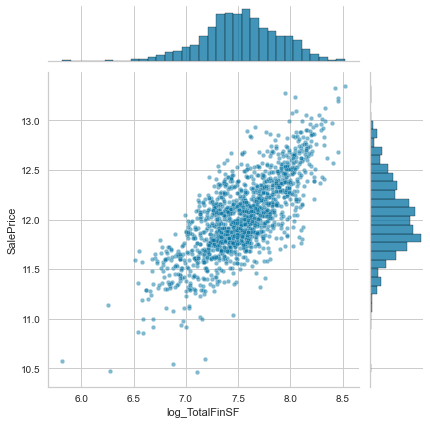

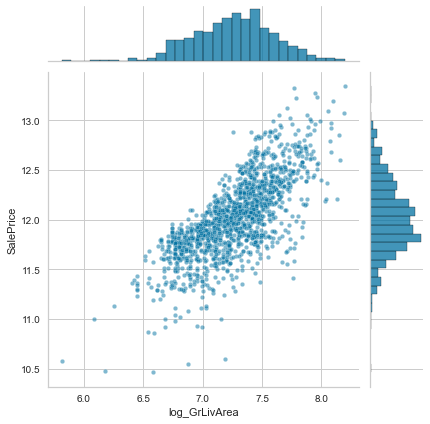

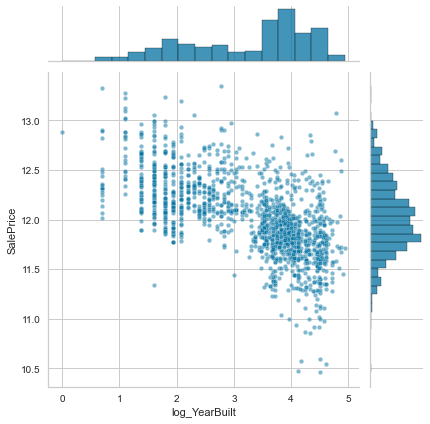

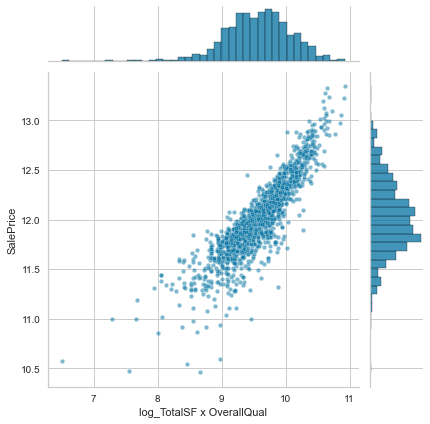

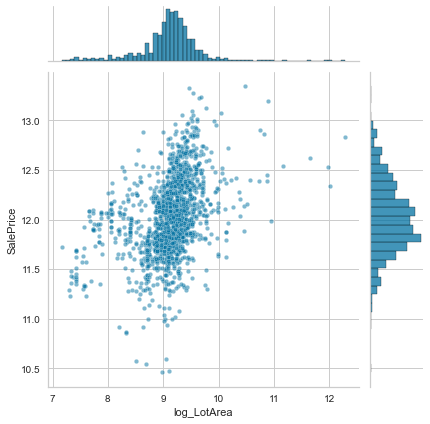

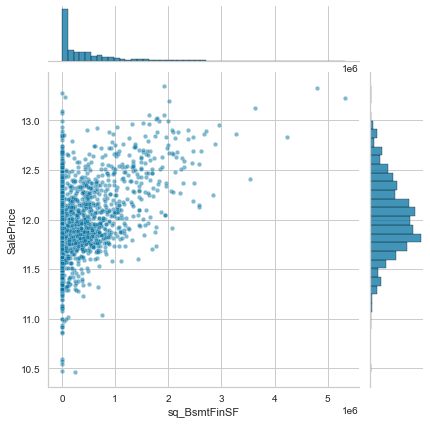

In [112]:
# few charts

z = df.loc[~df[response].isna()]

norm = matplotlib.colors.Normalize(vmin=0, vmax=21, clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Dark2)
colordict = {k: i for i, k in enumerate(z['MSZoning'].unique())}

for var in ['log_TotalFinSF','log_GrLivArea','log_YearBuilt','log_TotalSF x OverallQual','log_LotArea','sq_BsmtFinSF',]:
    sns.jointplot(var, 
                  response, 
                  data=z, 
                  alpha=0.5, 
                  s=20, 
#                  joint_kws={"color": z['MSZoning'].apply(lambda x: matplotlib.colors.to_hex(mapper.to_rgba(colordict[x])))}
                 )
    

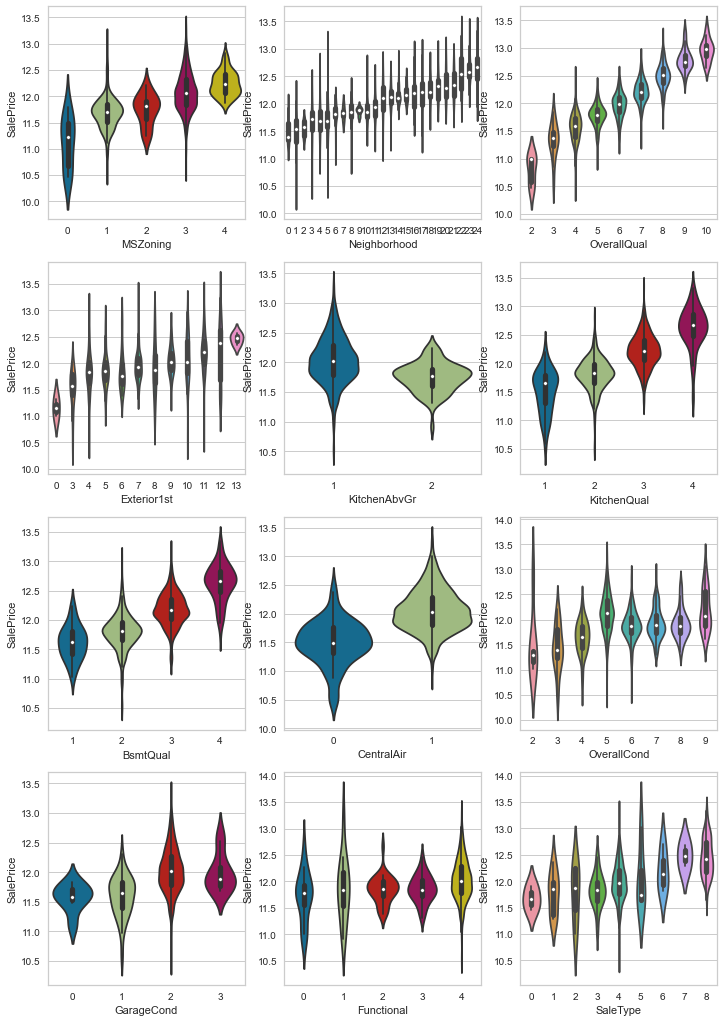

In [113]:
fig, ax = plt.subplots(figsize=(12,18), ncols=3, nrows=4)

for i, var in enumerate(['MSZoning','Neighborhood','OverallQual','Exterior1st','KitchenAbvGr','KitchenQual',
                         'BsmtQual', 'CentralAir','OverallCond','GarageCond','Functional','SaleType',]):
    sns.violinplot(x=var, y=response, data=z, ax = ax[i // 3][i % 3])    


In [114]:
widget_cats = []
widget_nums = []

for col in df.columns:
    if col == response:
        continue
    cardinality = len(df[col].value_counts())
    if cardinality <= 25:
        widget_cats.append(col)
    else:
        widget_nums.append(col)
        
widget_cats.sort()        
print(widget_cats)
print()
widget_nums.sort()
print(widget_nums)

['Alley', 'BedroomAbvGr', 'BldgType', 'BsmtBath', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireBathRatio', 'FireplaceQu', 'FireplaceQu x Fireplaces', 'Fireplaces', 'Foundation', 'FullBath', 'Functional', 'Functional x OverallQual', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageQual x GarageCond x GarageCars', 'GarageRatio', 'GarageType', 'HalfBath', 'Heating', 'HeatingQC', 'HeatingQC x Heating', 'HouseStyle', 'KitchenAbvGr', 'KitchenAbvGr x KitchenQual', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature', 'MoSold', 'Neighborhood', 'OverallCond', 'OverallQual', 'PavedDrive', 'PoolArea', 'PoolQC', 'RecentYearBuilt', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'TotRmsAbvGrd', 'TotalBath', 'Utilities', 'has2ndfloor'

Dropdown(description='Variable:', options=('1stFlrSF', '2ndFlrSF', '3SsnPorch', 'AvgBltRemod', 'AvgBltRemod x …

Dropdown(description='Color by:', index=51, options=('Alley', 'BedroomAbvGr', 'BldgType', 'BsmtBath', 'BsmtCon…

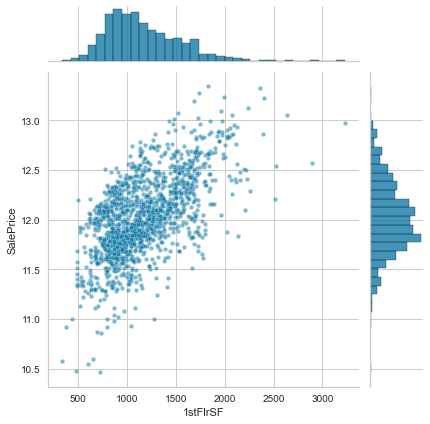

In [115]:
# interactive widget for continuous variables

do_refresh()
    


Dropdown(description='Cat:', options=('Alley', 'BedroomAbvGr', 'BldgType', 'BsmtBath', 'BsmtCond', 'BsmtExposu…

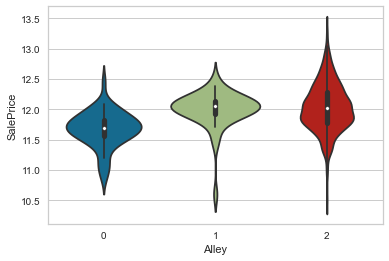

In [116]:
# interactive widget for categorical variables

def on_value_change3(change):
    do_refresh3(change['new'])

def do_refresh3(var=widget_cats[0]):

    clear_output()
    dropdown3 = widgets.Dropdown(
        options=widget_cats,
        value=var,
        description='Cat:',
        disabled=False,)
    display(dropdown3)
    dropdown3.observe(on_value_change3, names='value')
    
    z = df.loc[~df[response].isna()]

    sns.violinplot(x=var, y=response, data=z)    

do_refresh3()
        

In [117]:
### compare correlations of log, linear, square, add transforms as necessary
### make categorical if low cardinality

z = df.loc[~df[response].isna()]
logtransformlist = []
sqtransformlist = []

for col in z.columns:
    if z[col].dtype not in numeric_dtypes:
        continue
    elif col==response:
        continue
    log = (np.corrcoef(np.log1p(z[col]), z[response])[0,1])
    linear = (np.corrcoef(z[col], z[response])[0,1])
    square = (np.corrcoef(z[col]**2, z[response])[0,1])
    whichbiggest = np.argmax(np.array([abs(log), abs(linear), abs(square)]))
    print(col, 'log', log, 'linear', linear, 'square', square, whichbiggest)

    cardinality = len(df[col].value_counts())
    if cardinality > 12:
        if whichbiggest == 2:
            sqtransformlist.append(col)
        if whichbiggest == 0:
            logtransformlist.append(col)   
        
print('logs', logtransformlist)
print('squares', sqtransformlist)

MSSubClass log -0.00047989077349514507 linear -0.045144516906380425 square -0.09328233312170456 2
MSZoning log 0.41753275148485935 linear 0.4127975685290464 square 0.39689740866463447 0
Street log 0.0575948567771294 linear 0.05759485677712976 square 0.05759485677712976 1
Alley log 0.16242653532499038 linear 0.15754606824608697 square 0.14547854440633073 0
LandContour log 0.16278764070540458 linear 0.15709534886644316 square 0.1340251359108606 0
LotConfig log 0.12785450847566462 linear 0.144245719168227 square 0.153740678547008 2
Neighborhood log 0.6886270727823947 linear 0.7420311981460954 square 0.7282914789507744 1
Condition1 log 0.1850577692219326 linear 0.18380549468895435 square 0.14073313864977874 0
Condition2 log 0.10212307960484673 linear 0.10726550305334899 square 0.10860889036903426 2
BldgType log 0.18116649123563178 linear 0.18315594370218288 square 0.1751113359420227 1
HouseStyle log 0.11447612264187952 linear 0.13935729462582244 square 0.16966228611424955 2
RoofStyle log 0

In [118]:
predictors_simple = [p for p in df.columns if p != response]

In [119]:
# make these strings, forces dummification (could also just specify columns to dummify)
# transformstr = ['HeatingQC', 'BsmtQual', 'BsmtCond', 'BsmtFullBath', 'TotRmsAbvGrd', 'Fireplaces', 
#                 'GarageQual', 'TotalBath', 'BsmtBath',  'HalfBath', 'MSSubClass',]

dummy_cols = [
    'BldgType',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'BsmtQual',
    'CentralAir',
    'Condition1',
    'Condition2',
    'Electrical',
    'ExterCond',
    'ExterQual',
    'Exterior1st',
    'Exterior2nd',
    'Fence',
#    'FireplaceQu',
    'Fireplaces',
    'Foundation',
    'Functional',
    'GarageCars',
    'GarageCond',
    'GarageFinish',
    'GarageQual',
    'GarageType',
#    'GarageQual x GarageCond x GarageCars',
    'Heating',
    'HeatingQC',
    'HouseStyle',
    'KitchenQual',
#    'LandContour',
    'LandSlope',
    'LotConfig',
    'LotShape',
    'MSSubClass',
    'MSZoning',
    'MasVnrType',
    'MoSold',
    'Neighborhood',
    'OverallCond',
    'OverallQual',
    'PavedDrive',
    'RoofMatl',
    'RoofStyle',
    'SaleCondition',
    'SaleType',
#    'monthnum',
    'BedroomAbvGr',
    'BsmtBath',
#    'FireBathRatio',
    'HalfBath',
#    'MiscFeature',
    'PoolQC',
    'TotalBath',
#    'FireplaceQu x Fireplaces',
#    'GarageRatio',
#    'KitchenAbvGr x KitchenQual',
#    'Functional x OverallQual',
]


for col in dummy_cols:
    cardinality = df[col].value_counts().shape[0]
    #    if ((cardinality <= 4) and (cardinality > 2) or (col in labelencoded)):
    print(col, cardinality)
#    df[col] = df[col].apply(str)

predictors_nodummies = [p for p in df.columns if p != response and p not in dummy_cols]
print(predictors_nodummies)

tempdf = pd.get_dummies(df[dummy_cols],columns=dummy_cols)
predictors_dummies=list(tempdf.columns)
print()
print(predictors_dummies)
predictors_full = predictors_nodummies + predictors_dummies

df = pd.concat([df, tempdf], axis=1)
df.head()

BldgType 5
BsmtCond 3
BsmtExposure 5
BsmtFinType1 7
BsmtFinType2 7
BsmtQual 4
CentralAir 2
Condition1 9
Condition2 4
Electrical 4
ExterCond 4
ExterQual 4
Exterior1st 12
Exterior2nd 13
Fence 5
Fireplaces 4
Foundation 6
Functional 5
GarageCars 4
GarageCond 4
GarageFinish 4
GarageQual 3
GarageType 7
Heating 4
HeatingQC 4
HouseStyle 8
KitchenQual 4
LandSlope 3
LotConfig 5
LotShape 3
MSSubClass 13
MSZoning 5
MasVnrType 4
MoSold 12
Neighborhood 25
OverallCond 8
OverallQual 9
PavedDrive 2
RoofMatl 4
RoofStyle 6
SaleCondition 6
SaleType 9
BedroomAbvGr 7
BsmtBath 3
HalfBath 3
PoolQC 4
TotalBath 7
['Street', 'Alley', 'LandContour', 'MiscFeature', 'Utilities', 'FireplaceQu', 'YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'FullBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', '

,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,GarageType,MiscFeature,SaleType,SaleCondition,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,Electrical,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,YearBuilt,YearRemodAdd,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,MoSold,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,TotalFinSF,TotalSF,BsmtFinSF,PorchSF,TotalBath,BsmtBath,AvgBltRemod,PreWarYearBuilt,RecentYearBuilt,haspool,has2ndfloor,hasfireplace,LivAreaRatio,BedRatio,GarageRatio,BathRatio,LotRatio,FireBathRatio,TotalSF x OverallQual x OverallCond,TotalSF x OverallQual x Functional,AvgBltRemod x Functional x TotalFinSF,TotalSF x OverallQual,TotalSF x OverallCond,TotalFinSF x Functional,Functional x OverallQual,AvgBltRemod x OverallCond,AvgBltRemod x TotalFinSF,OverallCond x AvgBltRemod,BsmtFinSF x BsmtQual,BsmtFinSF x BsmtBath,KitchenAbvGr x KitchenQual,GarageCars x GarageYrBlt,GarageQual x GarageCond x GarageCars,HeatingQC x Heating,FireplaceQu x Fireplaces,monthnum,log_YearBuilt,log_GarageYrBlt,log_LotArea,log_LowQualFinSF,log_GrLivArea,log_WoodDeckSF,log_OpenPorchSF,log_EnclosedPorch,log_3SsnPorch,log_MiscVal,log_TotalFinSF,log_RecentYearBuilt,log_LivAreaRatio,log_BedRatio,log_GarageRatio,log_BathRatio,log_LotRatio,log_FireBathRatio,log_TotalSF x OverallQual x OverallCond,log_TotalSF x OverallQual,log_TotalSF x OverallCond,log_AvgBltRemod x OverallCond,log_AvgBltRemod x TotalFinSF,log_OverallCond x AvgBltRemod,sq_BsmtFinSF1,sq_BsmtFinSF2,sq_BsmtUnfSF,sq_2ndFlrSF,sq_BsmtFinSF,sq_PreWarYearBuilt,sq_Functional x OverallQual,sq_BsmtFinSF x BsmtQual,sq_BsmtFinSF x BsmtBath,BldgType_0,BldgType_1,BldgType_2,BldgType_3,BldgType_4,BsmtCond_1,BsmtCond_2,BsmtCond_3,BsmtExposure_0,BsmtExposure_1,BsmtExposure_2,BsmtExposure_3,BsmtExposure_4,BsmtFinType1_0,BsmtFinType1_1,BsmtFinType1_2,BsmtFinType1_3,BsmtFinType1_4,BsmtFinType1_5,BsmtFinType1_6,BsmtFinType2_0,BsmtFinType2_1,BsmtFinType2_2,BsmtFinType2_3,BsmtFinType2_4,BsmtFinType2_5,BsmtFinType2_6,BsmtQual_1,BsmtQual_2,BsmtQual_3,BsmtQual_4,CentralAir_0,CentralAir_1,Condition1_0,Condition1_1,Condition1_2,Condition1_3,Condition1_4,Condition1_5,Condition1_6,Condition1_7,Condition1_8,Condition2_1,Condition2_2,Condition2_4,Condition2_6,Electrical_0,Electrical_2,Electrical_3,Electrical_4,ExterCond_1,ExterCond_2,ExterCond_3,ExterCond_4,ExterQual_1,ExterQual_2,ExterQual_3,ExterQual_4,Exterior1st_0,Exterior1st_3,Exterior1st_4,Exterior1st_5,Exterior1st_6,Exterior1st_7,Exterior1st_8,Exterior1st_9,Exterior1st_10,Exterior1st_11,Exterior1st_12,Exterior1st_13,Exterior2nd_1,Exterior2nd_2,Exterior2nd_4,Exterior2nd_5,Exterior2nd_6,Exterior2nd_7,Exterior2nd_8,Exterior2nd_9,Exterior2nd_10,Exterior2nd_11,Exterior2nd_12,Exterior2nd_13,Exterior2nd_14,Fence_0,Fence_1,Fence_2,Fence_3,Fence_4,Fireplaces_0,Fireplaces_1,Fireplaces_2,Fireplaces_3,Foundation_0,Foundation_1,Foundation_2,Foundation_3,Foundation_4,Foundation_5,Functional_0,Functional_1,Functional_2,Functional_3,Functional_4,GarageCars_0,GarageCars_1,GarageCars_2,GarageCars_3,GarageCond_0,GarageCond_1,GarageCond_2,GarageCond_3,GarageFinish_0,GarageFinish_1,GarageFinish_2,GarageFinish_3,GarageQual_1,GarageQual_2,GarageQual_3,GarageType_0,GarageType_1,GarageType_2,GarageType_3,GarageType_4,GarageType_5,GarageType_6,Heating_1,Heating_2,Heating_4,Heating_5,HeatingQC_1,HeatingQC_2,HeatingQC_3,HeatingQC_4,HouseStyle_0,HouseStyle_1,HouseStyle_2,HouseStyle_3,HouseStyle_4,HouseStyle_5,HouseStyle_6,HouseStyle_7,KitchenQual_1,KitchenQual_2,KitchenQual_3,Kitch

In [120]:
# after dummifying, check for possible deletion or merger
low_variance = []

for i in df.columns:
    counts = df[i].value_counts()
    topval_count = counts.iloc[0]
    if topval_count / len(df) * 100 > 99.4:
        low_variance.append(i)

low_variance = list(low_variance)
low_variance


['Street',
 'Utilities',
 'PoolQC',
 'PoolArea',
 'haspool',
 'Condition1_5',
 'Condition1_6',
 'Condition2_1',
 'Condition2_2',
 'Condition2_6',
 'Electrical_0',
 'ExterCond_4',
 'Exterior1st_0',
 'Exterior1st_13',
 'Exterior2nd_7',
 'Exterior2nd_12',
 'Fence_1',
 'Fireplaces_3',
 'Foundation_3',
 'Foundation_4',
 'GarageCond_0',
 'GarageType_1',
 'Heating_1',
 'Heating_2',
 'HouseStyle_7',
 'LandSlope_2',
 'LotConfig_3',
 'Neighborhood_7',
 'OverallCond_2',
 'OverallQual_2',
 'RoofMatl_4',
 'RoofMatl_6',
 'RoofStyle_2',
 'RoofStyle_5',
 'SaleCondition_0',
 'SaleType_0',
 'SaleType_2',
 'SaleType_5',
 'SaleType_6',
 'SaleType_7',
 'BedroomAbvGr_0',
 'PoolQC_0',
 'PoolQC_1',
 'PoolQC_2',
 'PoolQC_3']

In [121]:
# drop only >= 2911 identical
dropcols = []
for col in df.columns:
    most_frequent = df[col].value_counts().iloc[0]
    if most_frequent  >= 2911:
        dropcols.append(col)
        print(col, most_frequent)

df.drop(columns=dropcols, inplace=True)
predictors_full = [p for p in predictors_full if p not in dropcols]
predictors_simple = [p for p in predictors_simple if p not in dropcols]

Utilities 2914
Exterior1st_13 2912
PoolQC_1 2913
PoolQC_2 2912
PoolQC_3 2912


In [122]:
df[predictors_full].shape

(2915, 377)

In [123]:
# bottom least important features
# lowimplasso = {'sq_BsmtQual', 'log_BsmtUnfSF', 'log_ScreenPorch', 'PoolArea',
#        'LowQualFinSF', 'PavedDrive', '3SsnPorch', 'RoofStyle', 'MoSold',
#        'ScreenPorch', 'Fence', 'sq_GarageQual', 'LotRatio', 'GarageCond',
#        'EnclosedPorch', 'BsmtFinSF2', 'LotFrontage', 'MiscVal',
#        'log_GarageCars', 'log_Fireplaces', 'sq_ExterQual', 'log_KitchenAbvGr',
#        'log_TotRmsAbvGrd', 'log_WoodDeckSF', 'sq_FireplaceQu', 'log_FullBath',
#        'log_BsmtFullBath', 'sq_log_GarageArea', 'sq_log_GarageCars',
#        'log_OpenPorchSF', 'sq_log_GrLivArea', 'sq_log_2ndFlrSF',
#        'sq_log_1stFlrSF', 'OverallCond', 'OverallQual', 'log_YearRemodAdd',
#        'log_TotalSF', 'SaleType', 'RoofMatl', 'sq_log_TotalBsmtSF', 'BsmtQual',
#        'HouseStyle', 'sq_log_LotFrontage', 'GrLivArea', 'log_LotRatio',
#        'log_2ndFlrSF', 'Fireplaces', 'GarageCars', 'Functional x OverallQual',
#        'TotalSF x OverallCond', 'TotalSF x OverallQual x Functional',
#        'BsmtFinSF1', 'BedRatio', 'BsmtUnfSF', 'TotalBsmtSF', 'haspool',
#        'AvgBltRemod', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF', 'TotalSF',
#        'TotalFinSF', 'GarageYrBlt', 'KitchenAbvGr', 'KitchenQual', 'HalfBath',
#        'log_BsmtFinSF1', 'log_LotFrontage', 'log_OverallCond x AvgBltRemod',
#        'GarageQual', 'log_AvgBltRemod x OverallCond', 'WoodDeckSF',
#        'log_BathRatio', 'log_BedRatio', 'log_LivAreaRatio', 'PoolQC',
#        'log_YearBuilt', 'YearRemodAdd', 'FireplaceQu x Fireplaces',
#        'HeatingQC x Heating', 'FullBath', 'has2ndfloor'}
               
# lowimplasso2 = {'TotalBath_2.5', 'PavedDrive_2', 'RoofStyle_5', 'OverallQual_10', 
#                 'TotalFinSF x Functional', 'MiscFeature', 'HalfBath_1', 
#                 'AvgBltRemod x TotalFinSF', 'BedroomAbvGr_2', 'TotalBath_3.5', 
#                 'SaleType_7', 'BedroomAbvGr_0', 'BsmtFullBath', 'BedroomAbvGr_4', 
#                 'RoofStyle_3', 'RoofStyle_2', 'BsmtFinSF x BsmtQual', 'TotalBath_1.5', 
#                 'RoofStyle_0', 'BsmtBath_0.5', 'RoofMatl_1', 'TotalSF x OverallQual', 
#                 'PoolQC_0', 'RoofMatl_3', 'HalfBath_0', 'Neighborhood_20', 'RoofMatl_4', 
#                 'OverallQual_4', 'OverallQual_5', 'CentralAir_1', 'Neighborhood_15', 
#                 'Neighborhood_7', 'Exterior2nd_5', 'Exterior2nd_7', 'Exterior2nd_9', 
#                 'Exterior2nd_11', 'Exterior2nd_13', 'Exterior2nd_14', 'Fence_0', 
#                 'Foundation_0', 'BsmtFinType1_4', 'Foundation_2', 'Foundation_4', 
#                 'BsmtFinType1_0', 'Functional_2', 'BsmtExposure_3', 'GarageCars_0', 
#                 'BsmtFinType2_0', 'Exterior2nd_2', 'Exterior2nd_1', 'Condition2_4', 
#                 'BsmtQual_3', 'Condition1_5', 'Condition1_6', 'Condition1_7', 
#                 'Condition2_1', 'Condition2_2', 'Condition2_6', 'BsmtFinType2_1', 
#                 'ExterCond_1', 'ExterCond_2', 'ExterQual_1', 'ExterQual_3', 
#                 'BsmtFinType2_6', 'Exterior1st_3', 'GarageCars_2', 'GarageCond_2', 
#                 'GarageCond_3', 'MSSubClass_60', 'LandSlope_0', 'LandSlope_1', 
#                 'LotConfig_0', 'LotShape_2', 'BsmtQual_4', 'MSSubClass_45', 
#                 'MSSubClass_75', 'KitchenQual_2', 'MSSubClass_80', 'MSSubClass_85', 
#                 'MSSubClass_90', 'MSSubClass_190', 'MSZoning_2', 'MSZoning_3', 'BldgType_2', 
#                 'KitchenQual_1', 'GarageFinish_0', 'BsmtCond_3', 'GarageFinish_3', 
#                 'GarageQual_1', 'GarageQual_2', 'GarageType_0', 'BsmtExposure_0', 
#                 'GarageType_6', 'Heating_2', 'HouseStyle_7', 'Heating_5', 'BldgType_4', 
#                 'HouseStyle_1', 'HouseStyle_2', 'HouseStyle_4', 'HouseStyle_6', 'MSSubClass_30'}

# lowimplasso = lowimplasso.union(lowimplasso2)
# predictors_full = [p for p in predictors_full if (p not in lowimplasso)]
# print(len(predictors_full))
# predictors_simple = [p for p in predictors_simple if (p not in lowimplasso)]
# print(len(predictors_simple))


In [124]:
# split off train, test
df_test = df.loc[df[response].isna()]
print(df_test.shape)
df_test.to_csv('df_test.csv', index=False)
df_test.to_pickle('df_test.pickle')

df = df.loc[~df[response].isna()]
df.to_csv('df_train.csv', index=False)
df.to_pickle('df_train.pickle')

print(df.shape)

X_train, X_test, y_train, y_test = train_test_split(df, df[response], test_size=.25)



(1459, 425)
(1456, 425)


### 4. Tune 

In [126]:
# use 10 kfolds for CV
kfolds = KFold(n_splits=10, shuffle=True, random_state=RANDOMSTATE)


In [127]:
# store best predictors by model
predictors_dict = {}

In [128]:
def evaluate(y_train, y_pred_train, y_test, y_pred_test):
    print('Train RMSE', np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train))))
    print('Train R-squared', r2_score(np.expm1(y_train), np.expm1(y_pred_train)))
    print('Train MAE', mean_absolute_error(np.expm1(y_train), np.expm1(y_pred_train)))
    print()
    print('Test RMSE', np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_test))))
    print('Test R-squared', r2_score(np.expm1(y_test), np.expm1(y_pred_test)))
    print('Test MAE', mean_absolute_error(np.expm1(y_test), np.expm1(y_pred_test)))

def evaluate2(y_train, y_pred_train, prefix = "Train"):
    print('%s RMSE (log)' % prefix, np.sqrt(mean_squared_error(y_train, y_pred_train)))
    print('%s RMSE' % prefix, np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train))))
    print('%s R-squared' % prefix, r2_score(np.expm1(y_train), np.expm1(y_pred_train)))
    print('%s MAE' % prefix, mean_absolute_error(np.expm1(y_train), np.expm1(y_pred_train)))
    return r2_score(np.expm1(y_train), np.expm1(y_pred_train))


In [129]:
%%time
# linear regression

reg = LinearRegression()
reg.fit(X_train[predictors_simple], y_train)

y_pred_train = reg.predict(X_train[predictors_simple])
y_pred_test = reg.predict(X_test[predictors_simple])
evaluate(y_train, y_pred_train, y_test, y_pred_test)

scores = np.sqrt(-cross_val_score(reg, df[predictors_simple], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))
print()
print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()


Train RMSE 17622.259053521848
Train R-squared 0.9458260334858414
Train MAE 11862.253248379138

Test RMSE 20901.368358866002
Test R-squared 0.9308137162330153
Test MAE 14049.052921653396

CV Score 0.1193 (STD 0.0158)

CPU times: user 693 ms, sys: 179 ms, total: 873 ms
Wall time: 131 ms


In [130]:
predictors_lasso = predictors_full
predictors_lasso = [p for p in predictors_lasso if p not in ['2ndFlrSF',
 '3SsnPorch',
 'Alley',
 'AvgBltRemod x OverallCond',
 'AvgBltRemod x TotalFinSF',
 'BathRatio',
 'BedRatio',
 'BedroomAbvGr_0',
 'BedroomAbvGr_2',
 'BedroomAbvGr_3',
 'BedroomAbvGr_6',
 'BldgType_0',
 'BldgType_1',
 'BldgType_2',
 'BldgType_3',
 'BsmtBath_0.0',
 'BsmtBath_0.5',
 'BsmtBath_1.0',
 'BsmtCond_1',
 'BsmtCond_2',
 'BsmtCond_3',
 'BsmtExposure_0',
 'BsmtExposure_2',
 'BsmtExposure_3',
 'BsmtFinSF',
 'BsmtFinSF x BsmtBath',
 'BsmtFinSF x BsmtQual',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFinType1_0',
 'BsmtFinType1_3',
 'BsmtFinType2_0',
 'BsmtFinType2_1',
 'BsmtFinType2_2',
 'BsmtFinType2_3',
 'BsmtFinType2_4',
 'BsmtFinType2_5',
 'BsmtFinType2_6',
 'BsmtQual_1',
 'BsmtQual_2',
 'BsmtQual_3',
 'BsmtQual_4',
 'BsmtUnfSF',
 'Condition1_0',
 'Condition1_2',
 'Condition1_4',
 'Condition1_5',
 'Condition1_6',
 'Condition1_7',
 'Condition1_8',
 'Condition2_1',
 'Condition2_2',
 'Condition2_4',
 'Condition2_6',
 'Electrical_0',
 'Electrical_2',
 'Electrical_3',
 'Electrical_4',
 'EnclosedPorch',
 'ExterCond_1',
 'ExterCond_3',
 'ExterCond_4',
 'ExterQual_1',
 'ExterQual_3',
 'ExterQual_4',
 'Exterior1st_0',
 'Exterior1st_11',
 'Exterior1st_12',
 'Exterior1st_3',
 'Exterior1st_6',
 'Exterior1st_7',
 'Exterior1st_8',
 'Exterior1st_9',
 'Exterior2nd_1',
 'Exterior2nd_10',
 'Exterior2nd_11',
 'Exterior2nd_12',
 'Exterior2nd_13',
 'Exterior2nd_14',
 'Exterior2nd_2',
 'Exterior2nd_4',
 'Exterior2nd_5',
 'Exterior2nd_6',
 'Exterior2nd_7',
 'Exterior2nd_8',
 'Exterior2nd_9',
 'Fence_1',
 'Fence_3',
 'Fence_4',
 'FireplaceQu',
 'FireplaceQu x Fireplaces',
 'Fireplaces_0',
 'Fireplaces_1',
 'Fireplaces_2',
 'Fireplaces_3',
 'Foundation_0',
 'Foundation_2',
 'Foundation_3',
 'Foundation_4',
 'Functional_0',
 'Functional_1',
 'Functional_2',
 'Functional_3',
 'Functional_4',
 'GarageCars_0',
 'GarageCars_2',
 'GarageCars_3',
 'GarageCond_0',
 'GarageCond_1',
 'GarageCond_2',
 'GarageCond_3',
 'GarageFinish_0',
 'GarageFinish_1',
 'GarageQual_1',
 'GarageQual_2',
 'GarageQual_3',
 'GarageRatio',
 'GarageType_0',
 'GarageType_1',
 'GarageType_3',
 'GarageType_4',
 'GarageType_5',
 'GarageType_6',
 'HalfBath_0',
 'HalfBath_2',
 'HeatingQC_1',
 'HeatingQC_2',
 'HeatingQC_3',
 'HeatingQC_4',
 'Heating_1',
 'Heating_2',
 'Heating_4',
 'Heating_5',
 'HouseStyle_0',
 'HouseStyle_1',
 'HouseStyle_3',
 'HouseStyle_4',
 'HouseStyle_5',
 'HouseStyle_6',
 'HouseStyle_7',
 'KitchenQual_1',
 'KitchenQual_2',
 'KitchenQual_3',
 'LandContour',
 'LandSlope_0',
 'LandSlope_1',
 'LandSlope_2',
 'LivAreaRatio',
 'LotConfig_1',
 'LotConfig_2',
 'LotConfig_3',
 'LotRatio',
 'LotShape_0',
 'LotShape_1',
 'LotShape_2',
 'LowQualFinSF',
 'MSSubClass_120',
 'MSSubClass_160',
 'MSSubClass_190',
 'MSSubClass_20',
 'MSSubClass_45',
 'MSSubClass_50',
 'MSSubClass_60',
 'MSSubClass_75',
 'MSSubClass_80',
 'MSSubClass_85',
 'MSSubClass_90',
 'MSZoning_2',
 'MasVnrType_0',
 'MasVnrType_1',
 'MiscFeature',
 'MiscVal',
 'MoSold_10',
 'MoSold_12',
 'MoSold_2',
 'MoSold_3',
 'MoSold_4',
 'MoSold_7',
 'MoSold_8',
 'MoSold_9',
 'Neighborhood_0',
 'Neighborhood_1',
 'Neighborhood_12',
 'Neighborhood_13',
 'Neighborhood_14',
 'Neighborhood_15',
 'Neighborhood_18',
 'Neighborhood_2',
 'Neighborhood_20',
 'Neighborhood_21',
 'Neighborhood_23',
 'Neighborhood_6',
 'Neighborhood_7',
 'Neighborhood_8',
 'Neighborhood_9',
 'OpenPorchSF',
 'OverallCond x AvgBltRemod',
 'OverallCond_2',
 'OverallCond_3',
 'OverallCond_4',
 'OverallCond_5',
 'OverallCond_6',
 'OverallCond_8',
 'OverallCond_9',
 'OverallQual_10',
 'OverallQual_2',
 'OverallQual_3',
 'OverallQual_4',
 'OverallQual_8',
 'PoolArea',
 'PoolQC_0',
 'PreWarYearBuilt',
 'RecentYearBuilt',
 'RoofMatl_1',
 'RoofMatl_3',
 'RoofMatl_4',
 'RoofMatl_6',
 'RoofStyle_0',
 'RoofStyle_1',
 'RoofStyle_2',
 'RoofStyle_3',
 'RoofStyle_4',
 'RoofStyle_5',
 'SaleCondition_0',
 'SaleCondition_3',
 'SaleCondition_4',
 'SaleType_0',
 'SaleType_1',
 'SaleType_2',
 'SaleType_3',
 'SaleType_5',
 'SaleType_6',
 'SaleType_7',
 'SaleType_8',
 'ScreenPorch',
 'Street',
 'TotRmsAbvGrd',
 'TotalBath_1.5',
 'TotalBath_2.0',
 'TotalBath_3.0',
 'TotalBath_3.5',
 'TotalBath_4.0',
 'TotalBsmtSF',
 'TotalFinSF',
 'TotalFinSF x Functional',
 'TotalSF',
 'TotalSF x OverallCond',
 'TotalSF x OverallQual',
 'TotalSF x OverallQual x Functional',
 'YearRemodAdd',
 'has2ndfloor',
 'hasfireplace',
 'haspool',
 'log_3SsnPorch',
 'log_AvgBltRemod x OverallCond',
 'log_BathRatio',
 'log_BedRatio',
 'log_EnclosedPorch',
 'log_FireBathRatio',
 'log_LivAreaRatio',
 'log_LotRatio',
 'log_LowQualFinSF',
 'log_MiscVal',
 'log_OpenPorchSF',
 'log_OverallCond x AvgBltRemod',
 'log_RecentYearBuilt',
 'log_TotalSF x OverallQual',
 'log_WoodDeckSF',
 'sq_BsmtFinSF1',
 'sq_BsmtFinSF2',
 'sq_BsmtUnfSF',
 'sq_Functional x OverallQual',
 'sq_PreWarYearBuilt',
 'LotArea', 'MSZoning_3', 'log_GarageYrBlt', 'log_GrLivArea'                                                                
                                                                ]]

predictors_dict['lasso'] = predictors_lasso
len(predictors_lasso)

100

alpha 0.00031622776601683794
Train RMSE 16953.833262962242
Train R-squared 0.949857811200056
Train MAE 11302.64797256242

Test RMSE 18025.104501416376
Test R-squared 0.94854516997542
Test MAE 12316.300693331248


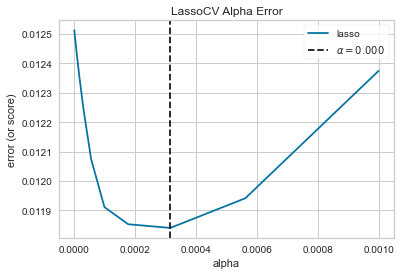

<AxesSubplot:title={'center':'LassoCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [132]:
#%%time
# lasso, visualize with yellowbrick
scaler = use_transform()
scaler.fit(X_train[predictors_lasso])
X_tr = scaler.transform(X_train[predictors_lasso])

#alphas = np.logspace(-5, 4, 19)
alphas = np.logspace(-6, -3, 13)
visualizer = AlphaSelection(LassoCV(alphas=alphas, max_iter=200000, cv=kfolds))
visualizer.fit(X_tr, y_train)

alpha = visualizer.estimator.alpha_
print('alpha', alpha)
y_pred_train = visualizer.predict(X_tr)
y_pred_test = visualizer.predict(scaler.transform(X_test[predictors_lasso]))
evaluate(y_train, y_pred_train, y_test, y_pred_test)

visualizer.poof()


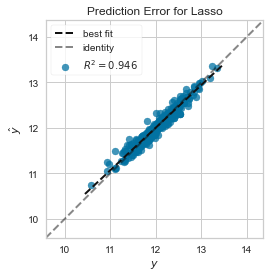

<AxesSubplot:title={'center':'Prediction Error for Lasso'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [133]:
#%%time
visualizer = PredictionError(Lasso(alpha=alpha))
visualizer.fit(X_tr, y_train)
visualizer.score(scaler.transform(X_test[predictors_lasso]), y_test)
visualizer.poof()


In [134]:
%%time
# tune LassoCV search space
# note train error is worse when using lasso regularization but test is better
# regularization reduces overfitting

lasso = make_pipeline(use_transform(),
                      LassoCV(alphas=np.logspace(-6, -4, 9),
                              max_iter=100000,
                              cv=kfolds))

scores = np.sqrt(-cross_val_score(lasso, df[predictors_lasso], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))
print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()

lasso.fit(X_train[predictors_lasso], y_train)

y_pred_train = lasso.predict(X_train[predictors_lasso])
y_pred_test = lasso.predict(X_test[predictors_lasso])
evaluate(y_train, y_pred_train, y_test, y_pred_test)

print('alpha', lasso._final_estimator.alpha_)


CV Score 0.1029 (STD 0.0112)

Train RMSE 16812.272174012283
Train R-squared 0.9506916696604418
Train MAE 11295.090151238412

Test RMSE 17862.304259257784
Test R-squared 0.9494704383392844
Test MAE 12284.904691151602
alpha 0.0001
CPU times: user 12.7 s, sys: 3.14 s, total: 15.8 s
Wall time: 2.06 s


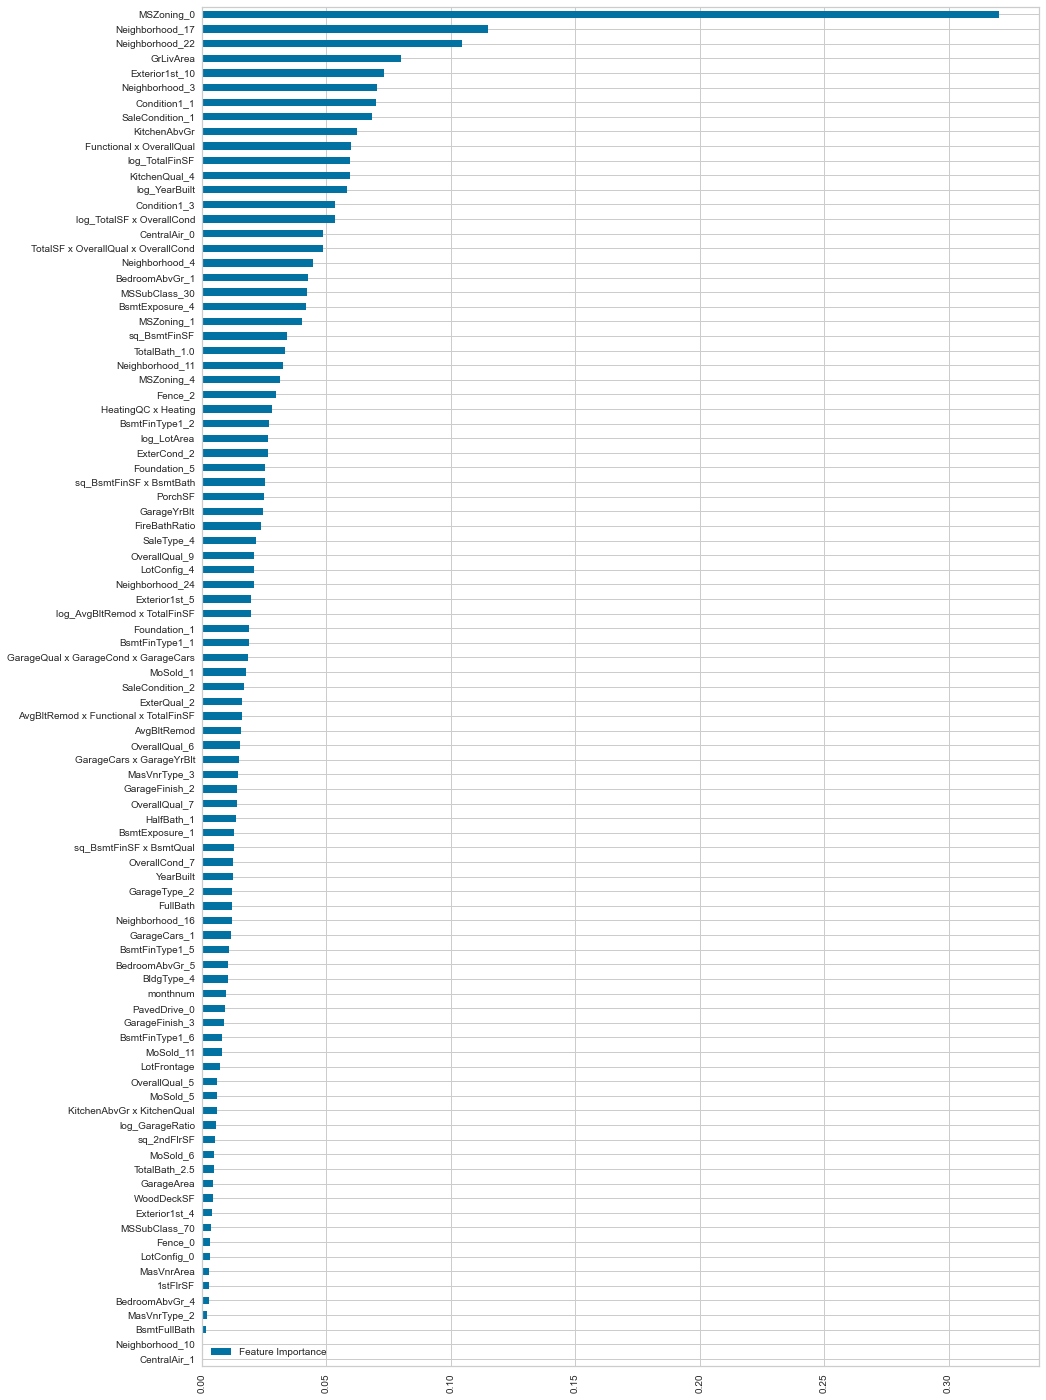

In [135]:
imp_lasso = pd.DataFrame({"Feature Importance" : lasso._final_estimator.coef_}, index=predictors_lasso)
imp_lasso["Feature Importance"]=abs(imp_lasso["Feature Importance"])
imp_lasso[imp_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

In [136]:
# run this on all features to get lowimportlasso - determine features with 0 coefficients
list(imp_lasso.loc[imp_lasso['Feature Importance']==0].index)

['log_TotalSF x OverallQual x OverallCond',
 'BsmtFinType1_4',
 'HouseStyle_2',
 'Neighborhood_5',
 'Neighborhood_19',
 'PavedDrive_2',
 'SaleCondition_5']

100
Train RMSE 16942.822644817294
Train R-squared 0.9499229194509782
Train MAE 11327.34606233218

Test RMSE 17705.516651774415
Test R-squared 0.9503535986773297
Test MAE 12104.412636677935
alpha 5.011872336272724


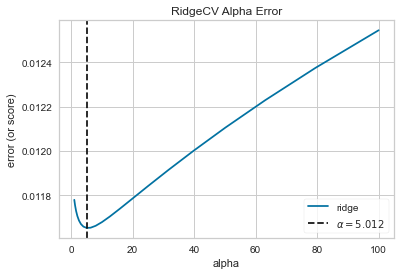

CPU times: user 862 ms, sys: 268 ms, total: 1.13 s
Wall time: 180 ms


<AxesSubplot:title={'center':'RidgeCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [137]:
%%time
predictors_ridge = predictors_lasso 
print(len(predictors_ridge))
predictors_dict['ridge'] = predictors_ridge
    
# visualize ridge with yellowbrick
scaler = use_transform()
scaler.fit(X_train[predictors_ridge])
X_tr = scaler.transform(X_train[predictors_ridge])

#alphas = np.logspace(-2, 3, 11)
alphas = np.logspace(0, 2, 21)
visualizer = AlphaSelection(RidgeCV(alphas=alphas))
visualizer.fit(X_tr, y_train)

y_pred_train = visualizer.predict(X_tr)
y_pred_test = visualizer.predict(scaler.transform(X_test[predictors_ridge]))
evaluate(y_train, y_pred_train, y_test, y_pred_test)

alpha = visualizer.estimator.alpha_
print('alpha', alpha)
visualizer.poof()

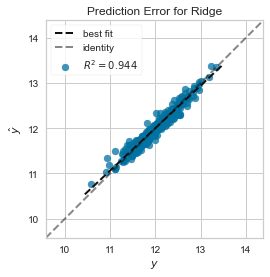

CPU times: user 816 ms, sys: 195 ms, total: 1.01 s
Wall time: 172 ms


<AxesSubplot:title={'center':'Prediction Error for Ridge'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [138]:
%%time
visualizer = PredictionError(Ridge(alpha=alpha))
visualizer.fit(X_train[predictors_ridge], y_train)
visualizer.score(X_test[predictors_ridge], y_test)
visualizer.poof()

In [139]:
%%time
# tune RidgeCV search space
alphas = np.logspace(0, 2, 21)

ridge = make_pipeline(use_transform(),
                      RidgeCV(cv=kfolds, alphas=alphas))

scores = np.sqrt(-cross_val_score(ridge, df[predictors_ridge], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))
print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()

ridge.fit(X_train[predictors_ridge], y_train)

y_pred_train = ridge.predict(X_train[predictors_ridge])
y_pred_test = ridge.predict(X_test[predictors_ridge])
evaluate(y_train, y_pred_train, y_test, y_pred_test)
print('alpha', ridge._final_estimator.alpha_)


CV Score 0.1034 (STD 0.0121)

Train RMSE 16989.56596333405
Train R-squared 0.9496462243650292
Train MAE 11342.478134825747

Test RMSE 17700.132778049916
Test R-squared 0.9503837869313342
Test MAE 12079.486729697224
alpha 6.309573444801933
CPU times: user 30.9 s, sys: 7.34 s, total: 38.3 s
Wall time: 4.94 s


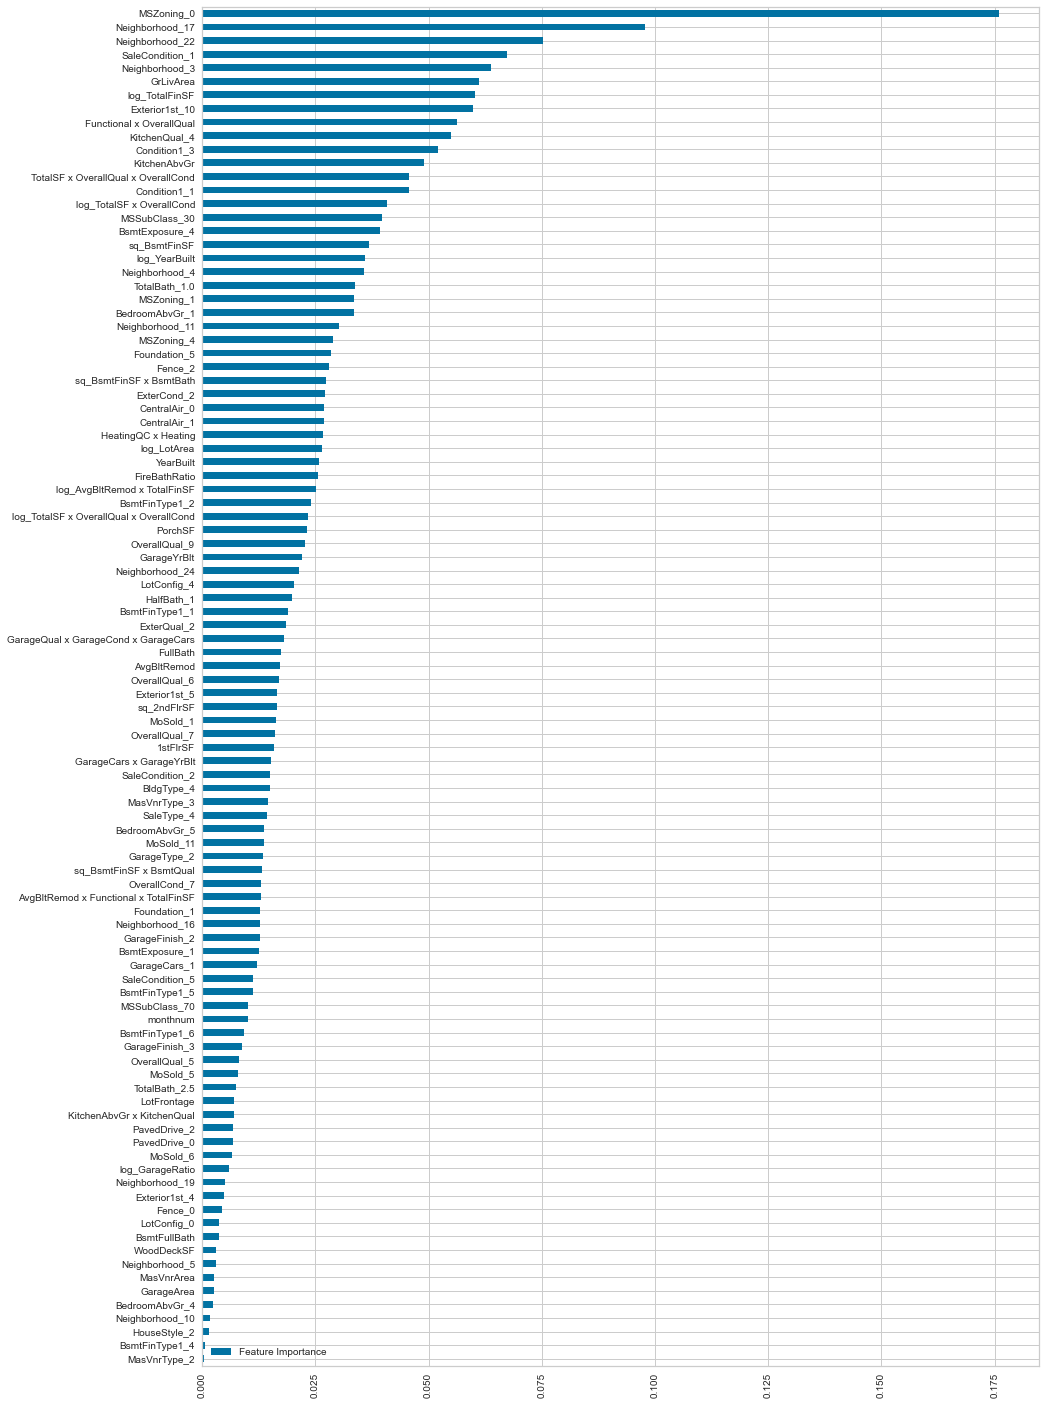

In [140]:
imp_ridge = pd.DataFrame({"Feature Importance" : ridge._final_estimator.coef_}, index=predictors_ridge)
imp_ridge["Feature Importance"]=abs(imp_ridge["Feature Importance"])
imp_ridge[imp_ridge["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

In [141]:
list(imp_ridge.loc[imp_ridge['Feature Importance']< 0.001].index)

['BsmtFinType1_4', 'MasVnrType_2']

In [142]:
%%time
# Tune ElasticNetCV search space for alphas and l1_ratio
print("ElasticNetCV")

predictors_elastic = predictors_lasso
predictors_elastic = [p for p in predictors_elastic if p not in []]
print(len(predictors_elastic))
predictors_dict['elasticnet'] = predictors_elastic

elasticnet = make_pipeline(use_transform(),
                           ElasticNetCV(max_iter=100000, 
                                        #l1_ratio=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99],
                                        l1_ratio=np.linspace(0.6, 0.8, 21),
                                        alphas=np.logspace(-4, -2, 21),
                                        cv=kfolds))

scores = np.sqrt(-cross_val_score(elasticnet, df[predictors_elastic], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))

print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()

elasticnet.fit(X_train[predictors_elastic], y_train)

y_pred_train = elasticnet.predict(X_train[predictors_elastic])
y_pred_test = elasticnet.predict(X_test[predictors_elastic])
evaluate(y_train, y_pred_train, y_test, y_pred_test)
print('l1_ratio', elasticnet._final_estimator.l1_ratio_)
print('alpha', elasticnet._final_estimator.alpha_)


ElasticNetCV
100
CV Score 0.1028 (STD 0.0114)

Train RMSE 16949.883880899437
Train R-squared 0.9498811696455971
Train MAE 11301.68094642638

Test RMSE 18004.13240219186
Test R-squared 0.9486648350823206
Test MAE 12304.174480463449
l1_ratio 0.6
alpha 0.0005011872336272725
CPU times: user 3min 16s, sys: 46 s, total: 4min 2s
Wall time: 31.1 s


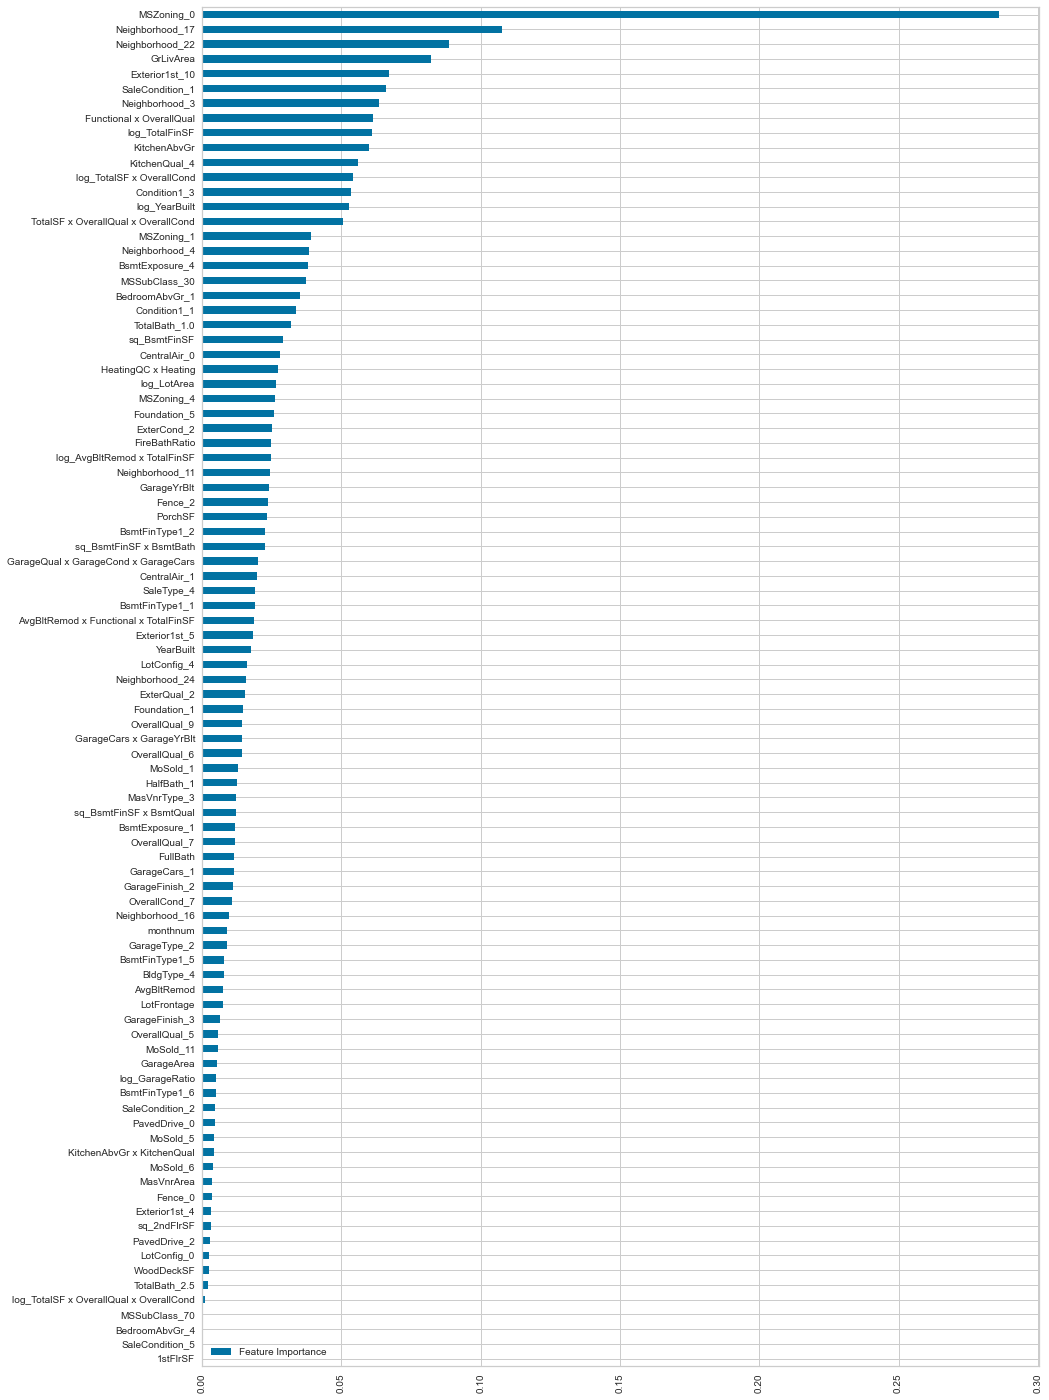

In [143]:
imp_elastic = pd.DataFrame({"Feature Importance" : elasticnet._final_estimator.coef_}, index=predictors_elastic)
imp_elastic["Feature Importance"]=abs(imp_elastic["Feature Importance"])
imp_elastic[imp_elastic["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)

plt.show()

In [144]:
sorted(list(imp_elastic.loc[imp_elastic['Feature Importance']< 0.001].index))

['1stFlrSF',
 'BedroomAbvGr_4',
 'BedroomAbvGr_5',
 'BsmtFinType1_4',
 'BsmtFullBath',
 'HouseStyle_2',
 'MSSubClass_70',
 'MasVnrType_2',
 'Neighborhood_10',
 'Neighborhood_19',
 'Neighborhood_5',
 'SaleCondition_5']

In [145]:
len(predictors_lasso)

100

In [84]:
import poolfunc
poolfunc.xv_train((1,2,3,4))

(1, 2, 3, 4)

In [86]:
#%%time
# tune KernelRidge using grid search with Pool.map
print("KernelRidge")
from multiprocessing import Pool

predictors_kr = predictors_lasso
predictors_kr = [p for p in predictors_kr if p not in []]
predictors_dict['kr'] = predictors_kr

kralphas = np.logspace(-5,0,6)
krcoef0s = np.linspace(1,10, 10)
krdegrees = [3]
krkernels = ['poly']

search_space = list(product(kralphas, krkernels, krdegrees, krcoef0s))

# def xv_train(arglist):
#     alpha, kernel, degree, coef0 = arglist
#    print(alpha, kernel, degree, coef0)
#     kr = make_pipeline(use_transform(),
#                        KernelRidge(alpha=alpha,
#                                    kernel=kernel,
#                                    degree=degree,
#                                    coef0=coef0,
#                                   ))
#     scores = np.sqrt(-cross_val_score(kr, df[predictors_kr], df[response],
#                                       scoring="neg_mean_squared_error",
#                                       cv=kfolds))    
#     print(alpha, kernel, degree, coef0, np.mean(scores), np.std(scores))
    
#     return (alpha, kernel, degree, coef0)

if __name__=="__main__":
    print('x)')
    with Pool(2) as pool:
        xval_list = pool.map(poolfunc.xv_train, search_space)


KernelRidge
x)


KeyboardInterrupt: 

In [79]:

ray.init(num_cpus=16, num_gpus=0)


2020-10-02 23:16:15,492	INFO services.py:1164 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.0.23',
 'raylet_ip_address': '192.168.0.23',
 'redis_address': '192.168.0.23:6379',
 'object_store_address': '/tmp/ray/session_2020-10-02_23-16-14_928616_58001/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-10-02_23-16-14_928616_58001/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2020-10-02_23-16-14_928616_58001',
 'metrics_export_port': 59976}

In [80]:
%%time
# tune KernelRidge using ray with grid search
print("KernelRidge")

predictors_kr = predictors_lasso
predictors_kr = [p for p in predictors_kr if p not in []]
predictors_dict['kr'] = predictors_kr

kralphas = np.logspace(-5,0,6)
kralpha = 0.03162277660168379

# linear, poly
# degree 1,2,3
coef0s = np.linspace(1,10, 10)
coef0=6

krdegrees = [1,2,3,4]
krdegree = 1

krkernels = ['poly']

search_space = {
    'alpha': tune.grid_search(kralphas.tolist()),
    'kernel': tune.choice(krkernels),
    'degree': tune.grid_search(krdegrees),
    'coef0': tune.grid_search(coef0s.tolist())
}


def xv_train(config):
    kr = make_pipeline(use_transform(),
                       KernelRidge(**config)
                      )
    # print(kr)
    scores = np.sqrt(-cross_val_score(kr, df[predictors_kr], df[response],
                                      scoring="neg_mean_squared_error",
                                      cv=kfolds))
    tune.report(mse=np.mean(scores),
                std=np.std(scores))
    
    return kr

analysis = tune.run(
    xv_train,
    config = search_space,
    local_dir="./results", 
    name="kr",
    metric="mse",
    mode='min',
    verbose=1,
)

Trial name,status,loc,alpha,coef0,degree,kernel,iter,total time (s),mse,std
xv_train_30361_00000,TERMINATED,,1e-05,1,1,poly,1,3.0582,0.103722,0.00994249
xv_train_30361_00001,TERMINATED,,0.0001,1,1,poly,1,3.21455,0.103707,0.00995744
xv_train_30361_00002,TERMINATED,,0.001,1,1,poly,1,3.24252,0.103571,0.0100955
xv_train_30361_00003,TERMINATED,,0.01,1,1,poly,1,3.20913,0.102866,0.0108431
xv_train_30361_00004,TERMINATED,,0.1,1,1,poly,1,3.21118,0.102942,0.0121744
xv_train_30361_00005,TERMINATED,,1,1,1,poly,1,3.12685,0.111829,0.0131205
xv_train_30361_00006,TERMINATED,,1e-05,2,1,poly,1,3.10383,0.103722,0.00994252
xv_train_30361_00007,TERMINATED,,0.0001,2,1,poly,1,3.11577,0.103707,0.00995774
xv_train_30361_00008,TERMINATED,,0.001,2,1,poly,1,3.09835,0.10357,0.0100983
xv_train_30361_00009,TERMINATED,,0.01,2,1,poly,1,3.12765,0.102862,0.0108554


In [83]:
analysis.results_df.columns

Index(['mse', 'std', 'time_this_iter_s', 'done', 'timesteps_total',
       'episodes_total', 'training_iteration', 'experiment_id', 'date',
       'timestamp', 'time_total_s', 'pid', 'hostname', 'node_ip',
       'time_since_restore', 'timesteps_since_restore',
       'iterations_since_restore', 'experiment_tag', 'config.alpha',
       'config.kernel', 'config.degree', 'config.coef0'],
      dtype='object')

In [84]:
# should be more rows, seems like a bug
results_df = analysis.results_df[['mse', 'std', 'config.alpha',
       'config.kernel', 'config.degree', 'config.coef0']].sort_values('mse').reset_index()
results_df

,trial_id,mse,std,config.alpha,config.kernel,config.degree,config.coef0
0,30361_00119,0.101551,0.012090,1.00000,poly,2,10.0
1,30361_00113,0.101586,0.012139,1.00000,poly,2,9.0
2,30361_00107,0.101635,0.012195,1.00000,poly,2,8.0
3,30361_00101,0.101704,0.012257,1.00000,poly,2,7.0
4,30361_00095,0.101803,0.012327,1.00000,poly,2,6.0
...,...,...,...,...,...,...,...
235,30361_00090,0.173592,0.019864,0.00001,poly,2,6.0
236,30361_00096,0.173613,0.019883,0.00001,poly,2,7.0
237,30361_00102,0.173629,0.019898,0.00001,poly,2,8.0
238,30361_00108,0.173642,0.019910,0.00001,poly,2,9.0


In [86]:
bestrow = results_df.sort_values('mse').iloc[0]
config = {'alpha': bestrow["config.alpha"], 
          'kernel': bestrow["config.kernel"], 
          'degree': bestrow["config.degree"], 
          'coef0': bestrow["config.coef0"]}
kr = make_pipeline(use_transform(),
                   KernelRidge(**config)
                  )
kr.fit(X_train[predictors_kr], y_train)
scores = np.sqrt(-cross_val_score(kr, df[predictors_kr], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))
print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()

y_pred_train = kr.predict(X_train[predictors_kr])
y_pred_test = kr.predict(X_test[predictors_kr])
evaluate(y_train, y_pred_train, y_test, y_pred_test)


CV Score 0.1016 (STD 0.0121)

Train RMSE 15374.117902064616
Train R-squared 0.9589979353023265
Train MAE 10358.02479137203

Test RMSE 17717.842066940808
Test R-squared 0.9495133077717618
Test MAE 12328.955780614508


In [88]:
# tune kernel ridge using ray and hyperopt
# https://docs.ray.io/en/latest/tune/examples/hyperopt_example.html

search_space = {
    "alpha" : hp.loguniform('alpha', 1e-5,1e0),
    "coef0" : hp.uniform('coef0', 1, 10),
    "degree": hp.uniformint('degree', 1, 4),
    'kernel': hp.choice('kernel', ['poly']),
    
}

hyperopt_search = HyperOptSearch(search_space, metric="mse", mode="min")

analysis = tune.run(
    xv_train,
    num_samples=100,
    search_alg=hyperopt_search,
    local_dir="./results", 
    name="krhp",
    metric="mse",
    mode='min',
    verbose=1,
)



Trial name,status,loc,alpha,coef0,degree,kernel,iter,total time (s),mse,std
xv_train_6a3e5abe,TERMINATED,,2.62242,1.5649,3,poly,1,4.17047,0.108335,0.0123554
xv_train_6a3ff86a,TERMINATED,,1.11846,1.1908,2,poly,1,3.11669,0.10906,0.0124095
xv_train_6a41f8a4,TERMINATED,,1.06479,1.86277,3,poly,1,4.29889,0.103422,0.0126919
xv_train_6a43dfe8,TERMINATED,,1.10313,2.7867,2,poly,1,2.97977,0.102953,0.0126191
xv_train_6a45dd3e,TERMINATED,,2.61874,6.19374,2,poly,1,2.99077,0.1031,0.0126764
xv_train_6a47cf0e,TERMINATED,,2.37142,2.33496,2,poly,1,2.96256,0.106054,0.0128085
xv_train_6a49adec,TERMINATED,,2.55628,7.46734,2,poly,1,3.23866,0.102789,0.0125898
xv_train_6a4ba12e,TERMINATED,,2.50411,2.14284,3,poly,1,4.24524,0.10371,0.0125944
xv_train_6a4d36ce,TERMINATED,,1.72251,8.86869,2,poly,1,3.19337,0.102081,0.0123423
xv_train_6a4ed4fc,TERMINATED,,2.20146,1.75211,1,poly,1,3.15755,0.114308,0.0136687


In [89]:
analysis.results_df.columns

Index(['mse', 'std', 'time_this_iter_s', 'done', 'timesteps_total',
       'episodes_total', 'training_iteration', 'experiment_id', 'date',
       'timestamp', 'time_total_s', 'pid', 'hostname', 'node_ip',
       'time_since_restore', 'timesteps_since_restore',
       'iterations_since_restore', 'experiment_tag', 'config.alpha',
       'config.coef0', 'config.degree', 'config.kernel'],
      dtype='object')

In [90]:
results_df = analysis.results_df[['mse', 'std', 'config.kernel', 'config.alpha', 'config.degree', 'config.coef0']].sort_values('mse').reset_index()
results_df


,trial_id,mse,std,config.kernel,config.alpha,config.degree,config.coef0
0,6b1a026c,0.101654,0.012165,poly,1.110456,2,9.127152
1,6b35f2d8,0.101799,0.012322,poly,1.010677,2,6.114742
2,6b390b6c,0.101883,0.012352,poly,1.091693,2,6.052878
3,6a4d36ce,0.102081,0.012342,poly,1.722515,2,8.868686
4,6ae94028,0.102092,0.012421,poly,1.292362,2,5.919528
...,...,...,...,...,...,...,...
95,6a7e78c4,0.120489,0.012155,poly,2.260019,4,7.744337
96,6a7b73c2,0.121011,0.012922,poly,1.802608,4,1.093756
97,6b299696,0.121078,0.012150,poly,1.933972,4,7.371787
98,6a759f88,0.121728,0.012131,poly,2.170005,4,8.119895


In [88]:
# tune kernel ridge using ray and bayesopt
# bayesian https://docs.ray.io/en/latest/tune/examples/bayesopt_example.html

predictors_kr = predictors_lasso
def xv_train(config):
    kr = make_pipeline(use_transform(),
                       KernelRidge(**config)
                      )
    # print(kr)
    scores = np.sqrt(-cross_val_score(kr, df[predictors_kr], df[response],
                                      scoring="neg_mean_squared_error",
                                      cv=kfolds))
    tune.report(mse=np.mean(scores),
                std=np.std(scores))
    
    return kr

In [85]:
tune_kwargs = {
    "num_samples": 100,
    "config": {
        "alpha" : tune.loguniform(1e-5, 1e0),
        "coef0" : tune.uniform(1.0, 10.0),
        "degree": tune.uniform(1, 4),
        'kernel': 'poly'
    }
}

algo = BayesOptSearch(utility_kwargs={
    "kind": "ucb",
    "kappa": 2.5,
    "xi": 0.0
})

algo = ConcurrencyLimiter(algo, max_concurrent=4)
scheduler = AsyncHyperBandScheduler()

analysis = tune.run(
    xv_train,
    search_alg=algo,
    scheduler=scheduler,
    local_dir="./results", 
    name="krbayes",
    metric="mse",
    mode='min',
    verbose=1,
    **tune_kwargs
)



Trial name,status,loc,alpha,coef0,degree,iter,total time (s),mse,std
xv_train_b6153ed8,TERMINATED,,0.374546,9.55643,3.19598,1,1.31808,0.11875,0.0121359
xv_train_b6169e2c,TERMINATED,,0.598662,2.40417,1.46798,1,1.31093,0.103749,0.0127229
xv_train_b618055a,TERMINATED,,0.058093,8.79559,2.80335,1,1.3059,0.124044,0.0120741
xv_train_b6191346,TERMINATED,,0.708075,1.18526,3.90973,1,1.31288,0.109522,0.0132406
xv_train_b746b20a,TERMINATED,,0.832444,2.91105,1.54547,1,1.24864,0.103935,0.0127751
xv_train_b74ab56c,TERMINATED,,0.183413,3.73818,2.57427,1,1.25903,0.106447,0.0122787
xv_train_b74ed6e2,TERMINATED,,0.431951,3.62106,2.83556,1,1.31052,0.105236,0.0123595
xv_train_b7541a1c,TERMINATED,,0.139502,3.6293,2.09909,1,1.3124,0.103097,0.0121986
xv_train_b875e34e,TERMINATED,,0.456075,8.06658,1.59902,1,1.17362,0.102047,0.0122253
xv_train_b87ccd4e,TERMINATED,,0.514239,6.33173,1.13935,1,1.18471,0.104367,0.0128837


In [86]:
results_df = analysis.results_df[['mse', 'std', 'config.alpha',
       'config.kernel', 'config.degree', 'config.coef0']].sort_values('mse').reset_index()
results_df

,trial_id,mse,std,config.alpha,config.kernel,config.degree,config.coef0
0,d1b2707a,0.101412,0.012121,0.954114,poly,2.217304,7.629660
1,c3c43552,0.101440,0.012169,1.000000,poly,2.169058,7.151590
2,c29e441a,0.101442,0.012144,1.000000,poly,2.273276,7.168509
3,c2bf1b7c,0.101454,0.012142,1.000000,poly,2.288699,7.169014
4,c30cd18c,0.101477,0.012139,1.000000,poly,2.310180,7.168956
...,...,...,...,...,...,...,...
95,bff6a374,0.166916,0.018065,0.000010,poly,2.453867,2.509296
96,cb4d83c8,0.172637,0.019472,0.000010,poly,2.295258,7.251465
97,cab74c32,0.172811,0.019544,0.000010,poly,2.257091,7.281862
98,bdf0b420,0.173692,0.019985,0.000010,poly,1.973910,5.433857


In [89]:
bestrow = results_df.sort_values('mse').iloc[0]
config = {'alpha': bestrow["config.alpha"], 
          'kernel': bestrow["config.kernel"], 
          'degree': bestrow["config.degree"], 
          'coef0': bestrow["config.coef0"]}
kr = make_pipeline(use_transform(),
                   KernelRidge(**config)
                  )
kr.fit(X_train[predictors_kr], y_train)
scores = np.sqrt(-cross_val_score(kr, df[predictors_kr], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))
print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()

y_pred_train = kr.predict(X_train[predictors_kr])
y_pred_test = kr.predict(X_test[predictors_kr])
evaluate(y_train, y_pred_train, y_test, y_pred_test)


CV Score 0.1014 (STD 0.0121)

Train RMSE 14800.188952034217
Train R-squared 0.9617606288199703
Train MAE 9918.803884822428

Test RMSE 17588.78219159511
Test R-squared 0.9506161117379688
Test MAE 12229.348911417474


In [ ]:
%%time
# tune SVR
print("SVR")

predictors_svr = predictors_lasso
predictors_svr = [p for p in predictors_svr if p not in []]
predictors_dict['svr'] = predictors_svr

Cs = np.logspace(0,3,7)
C = 3.1622776601683795

epsilons = np.logspace(-5,-2,7)
epsilon = 0.03162277660168379

svrgammas = np.logspace(-5,-2,7)
svrgamma = 0.001

svrdegrees = [3]

def xv_train(config):
    svr = make_pipeline(use_transform(),
                        SVR(**config))
    # print(svr)
    scores = np.sqrt(-cross_val_score(svr, df[predictors_svr], df[response],
                                      scoring="neg_mean_squared_error",
                                      cv=kfolds))
    tune.track.log(mse=np.mean(scores),
                   std=np.std(scores))
    
    return svr

analysis = tune.run(
    xv_train,
    config = {'kernel': tune.choice(['rbf']),
              'degree': tune.grid_search(svrdegrees), 
              'gamma': tune.grid_search(svrgammas.tolist()),
              'coef0': 0.0, 
              'tol' :0.001, 
              'C': tune.grid_search(Cs.tolist()), 
              'epsilon': tune.grid_search(epsilons.tolist()), 
              'shrinking': True, 
              'cache_size': 200, 
              'verbose': False, 
              'max_iter': -1},
    local_dir="./results", 
    name="svr"    
)

In [ ]:
analysis.dataframe().sort_values('mse').head()

In [ ]:
bestrow = analysis.dataframe().sort_values('mse').iloc[0]
config = {'kernel': 'rbf',
          'degree': 3, 
          'gamma': bestrow['config/gamma'],
          'coef0': 0.0, 
          'tol' :0.001, 
          'C': bestrow['config/C'], 
          'epsilon': bestrow['config/epsilon'], 
          'shrinking': True, 
          'cache_size': 200, 
          'verbose': False, 
          'max_iter': -1}
svr = make_pipeline(use_transform(),
                    SVR(**config))
svr.fit(X_train[predictors_svr], y_train)
scores = np.sqrt(-cross_val_score(svr, df[predictors_svr], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))
print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()

y_pred_train = svr.predict(X_train[predictors_svr])
y_pred_test = svr.predict(X_test[predictors_svr])
evaluate(y_train, y_pred_train, y_test, y_pred_test)


In [ ]:
%%time
# tune Gradient Boost
print("Gradient Boost")

predictors_gb=[p for p in predictors_lasso if p not in ['BsmtExposure_3',
 'BsmtFinType2_3',
 'Exterior1st_4',
 'Exterior1st_5',
 'Fence_2',
 'LandSlope_1',
 'MSZoning_0',
 'MoSold_11',
 'MoSold_5',
 'MoSold_8',
 'OverallQual_6',
 'PavedDrive_2',
 'SaleType_4',
 'TotalBath_2.5',
 'log_LowQualFinSF',
                                                       ]]
print(len(predictors_gb))
predictors_dict['gb'] = predictors_gb

gbestimatorss = [int(z) for z in np.logspace(2,4,9).tolist()]
print(gbestimatorss)
gbdepths = [2,3,4]
gblearnrates = np.logspace(-4, -2, 3).tolist()

def xv_train(config):
    gb = make_pipeline(use_transform(),
                       GradientBoostingRegressor(**config))
    # print(gb)
    scores = np.sqrt(-cross_val_score(gb, df[predictors_gb], df[response],
                                      scoring="neg_mean_squared_error",
                                      cv=kfolds))
    tune.track.log(mse=np.mean(scores),
                   std=np.std(scores))
    return gb

analysis = tune.run(
    xv_train,
    config = {'n_estimators': tune.grid_search(gbestimatorss),
              'learning_rate': tune.grid_search(gblearnrates),
              'max_depth': tune.grid_search(gbdepths),
              'max_features': 'sqrt',
              'min_samples_leaf': 16, 
              'loss': 'huber', 
              'subsample': 0.8, 
              'random_state': RANDOMSTATE},
    local_dir="./results", 
    name="gb"    
)

analysis.dataframe().sort_values('mse').head()

In [ ]:
bestrow = analysis.dataframe().sort_values('mse').iloc[0]
config = {'n_estimators': bestrow['config/n_estimators'],
          'learning_rate': bestrow['config/learning_rate'],
          'max_depth': bestrow['config/max_depth'],
          'max_features': bestrow['config/max_features'],
          'min_samples_leaf': bestrow['config/min_samples_leaf'],
          'loss': bestrow['config/loss'],
          'subsample': bestrow['config/subsample'],
          'random_state': bestrow['config/random_state'],
         }
gb = make_pipeline(use_transform(),
                   GradientBoostingRegressor(**config))
gb.fit(X_train[predictors_gb], y_train)
scores = np.sqrt(-cross_val_score(gb, df[predictors_gb], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))
print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()

y_pred_train = gb.predict(X_train[predictors_gb])
y_pred_test = gb.predict(X_test[predictors_gb])
evaluate(y_train, y_pred_train, y_test, y_pred_test)


In [ ]:
imp_gb = pd.DataFrame({"Feature Importance" : gb._final_estimator.feature_importances_}, index=predictors_gb)
imp_gb["Feature Importance"]=abs(imp_gb["Feature Importance"])
imp_gb[imp_gb["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()


In [ ]:
sorted(list(imp_gb.loc[imp_gb['Feature Importance']<=0.0001].index))


In [ ]:
# https://github.com/ray-project/ray/blob/master/python/ray/tune/examples/hyperopt_example.py
# change np.arange to hp.uniform and log version
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',     np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',         np.arange(2, 12, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight',  np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 0.8),
    'subsample':        hp.uniform('subsample', 0.4, 0.8),
    'n_estimators':     hp.choice('n_estimators',  [int(h) for h in list(np.logspace(2,5,13))]),
    'reg_alpha':        hp.choice('reg_alpha',         np.logspace(-2, 0, 5).tolist()),
}
xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


xgboost tuning

- use early stopping. early_stopping_rounds=50 # stop if no improvement after 50 rounds
                    eval_set=eval_set,
                    eval_metric='rmse',
                    early_stopping_rounds=50,



In [ ]:
class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def xgb_reg(self, para):
        reg = xgboost.XGBRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def lgb_reg(self, para):
        reg = lgb.LGBMRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def ctb_reg(self, para):
        reg = ctb.CatBoostRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}

In [ ]:
from hyperopt.mongoexp import MongoTrials

trials = MongoTrials('mongo://localhost:1234/foo_db/jobs', exp_key='exp1')

# download ray 1.0
# add w&b
# run with ray tune
# train with hyperopt and other libs

In [ ]:
predictors_xgb = predictors_lasso

XGB_train, XGB_test, yxgb_train, yxgb_test = train_test_split(df[predictors_xgb], df[response], test_size=.25)

obj = HPOpt(XGB_train, XGB_test, yxgb_train, yxgb_test)

xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=trials, algo=tpe.suggest, max_evals=1000)

In [ ]:
%%time
# tune XGBoost
print("XGBoost")
# XGboost - sophisticated decision tree model
# tuned sequentially

predictors_xgb = predictors_lasso
predictors_dict['xgb'] = predictors_xgb
print(len(predictors_xgb))
#n_estimators_xgb: number of base learner trees
n_estimators_xgbs=[100, 178, 316, 562, 1000, 1778, 3162, 5623, 10000]
n_estimators_xgb = 5623

#max_depth: max depth per base tree
max_depths = list(range(2,12))
max_depth = 3

#subsample: row subsampling rate (similar to RF)
subsamples = np.linspace(0.4, 0.8, 9).tolist()
subsample = 0.55

#colsample_bytree: feature subsampling rate (similar to RF)
colsample_bytrees = np.linspace(0.1, 0.8, 15).tolist()
colsample_bytree = 0.15

reg_alphas = np.logspace(-7, 0, 15).tolist()
reg_alpha = 1e-05

gammas = [0, 1, 5]
gammas = [0]
gamma = 0

#learning_rate_xgb: shrinkage factor applied to each base tree update
learning_rate_xgbs = np.logspace(-2, 0, 5)
learning_rate_xgbs = [0.01]
learning_rate_xgb = 0.01

def xv_train(config):
    xgb = make_pipeline(use_transform(),
                        XGBRegressor(**config))
    # print(xgb)
    scores = np.sqrt(-cross_val_score(xgb, df[predictors_xgb], df[response],
                                      scoring="neg_mean_squared_error",
                                      cv=kfolds))
    tune.track.log(mse=np.mean(scores),
                   std=np.std(scores))
    
    return xgb

analysis = tune.run(
    xv_train,
    config = {
        'objective': 'reg:squarederror',
        'max_depth': tune.grid_search(max_depths),
        'n_estimators': tune.grid_search(n_estimators_xgbs),
        'gamma': tune.grid_search(gammas),
        'subsample': tune.grid_search(subsamples),
        'colsample_bytree': tune.grid_search(colsample_bytrees),
        'learning_rate': tune.grid_search(learning_rate_xgbs),
        'min_child_weight': 0,
        'reg_alpha': tune.grid_search(reg_alphas),
        'n_jobs': -1
    },
    local_dir="./results", 
    name="xgb"    
)



In [ ]:
analysis.dataframe().sort_values('mse').head()


In [ ]:
bestrow = analysis.dataframe().sort_values('mse').iloc[0]
config = {'objective': bestrow['config/objective'],
          'max_depth': bestrow['config/max_depth'],
          'n_estimators': bestrow['config/n_estimators'],
          'gamma': bestrow['config/gamma'],
          'subsample': bestrow['config/subsample'],
          'colsample_bytree': bestrow['config/colsample_bytree'],
          'learning_rate': bestrow['config/learning_rate'],
          'min_child_weight': bestrow['config/min_child_weight'],
          'reg_alpha': bestrow['config/reg_alpha'],
          'n_jobs': bestrow['config/n_jobs'],
         }

xgb = make_pipeline(use_transform(),
                   GradientBoostingRegressor(**config))
xgb.fit(X_train[predictors_xgb], y_train)
scores = np.sqrt(-cross_val_score(xgb, df[predictors_xgb], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))
print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()

y_pred_train = xgb.predict(X_train[predictors_xgb])
y_pred_test = xgb.predict(X_test[predictors_xgb])
evaluate(y_train, y_pred_train, y_test, y_pred_test)

In [ ]:
plot_importance(xgb._final_estimator, max_num_features=30, height=0.5);

In [ ]:
imp_xgb = pd.DataFrame({"Feature Importance" : xgb.feature_importances_}, index=predictors_xgb)
imp_xgb["Feature Importance"]=abs(imp_xgb["Feature Importance"])
imp_xgb[imp_xgb["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()


In [ ]:
sorted(list(imp_xgb.loc[imp_xgb['Feature Importance']<0.0001].index))

In [ ]:
%%time
# get xgboost interactions, terms that show up in same prediction trees
# alternatives to find interactions:
#   generate many/all interactions (product, ratio, top 30 vs rest) and correlate vs. the residual
#   generate many/all interactions and do lasso to see which ones are retained
interactions = xgb._Booster.predict(xgboost.DMatrix(df[predictors_xgb]), pred_interactions=True)
interaction_matrix = np.mean(np.abs(interactions), axis=0)
# last row, col = bias term
interaction_matrix = interaction_matrix[:-1,:-1]
np.fill_diagonal(interaction_matrix, 0)
interaction_matrix.shape


In [ ]:
# chart
sns.heatmap(np.abs(interaction_matrix), cmap="YlOrRd", linewidths=0, annot=False, annot_kws={'size': 9}, fmt='.4f');


In [ ]:
# print high interaction pairs
# last row, col = bias term
# could also sort, not print out symmetrical pairs
nrows, ncols = interaction_matrix.shape
z = interaction_matrix.copy()[:nrows, :ncols]
z = z.reshape((nrows * ncols))
z.sort()
threshold = z[-100]
print(threshold)
threshold = .0002
interaction_list = []

for i in range(interaction_matrix.shape[0]-1):
    for j in range(interaction_matrix.shape[1]-1):
        # no dupes
        if j > i:
            continue
        if interaction_matrix[i,j] > threshold:
            interaction_list.append((predictors_xgb[i], predictors_xgb[j], interaction_matrix[i,j]))

for tup in sorted(interaction_list, key=lambda x: -x[2]):
    print(tup)
        

In [ ]:
%%time
# tune LightGBM
print("LightGBM")

predictors_lgbm = predictors_lasso
predictors_dict['lgbm'] = predictors_lgbm
print(len(predictors_lgbm))

#n_estimators_lgbm: number of base learner trees
n_estimators_lgbms=[100, 178, 316, 562, 1000, 1778, 3162, 5623, 10000]
n_estimators_lgbm = 5623

#max_depth: max depth per base tree
num_leavess = range(2,12)
num_leaves = 5

#subsample: row subsampling rate (similar to RF)
bagging_fractions = np.linspace(0.5, 0.8, 11)
bagging_fraction = 0.75

#colsample_bytree: feature subsampling rate (similar to RF)
feature_fractions = np.linspace(0.05, 0.3, 26)
feature_fraction = 0.1

#learning_rate: shrinkage factor applied to each base tree update
learning_rates = np.logspace(-3, 0, 7)
learning_rates = [0.01]
learning_rate_lgbm = 0.01

for i in [1]:
    print(num_leaves,
          n_estimators_lgbm,
          bagging_fraction,
          feature_fraction,
         )
    
    lgbm = LGBMRegressor(objective='regression',
                         num_leaves=num_leaves,
                         learning_rate=learning_rate_lgbm,
                         n_estimators=n_estimators_lgbm,
                         max_bin=200,
                         bagging_fraction=bagging_fraction,
                         feature_fraction=feature_fraction,
                         feature_fraction_seed=7,
                         min_data_in_leaf=2,
                         verbose=-1,
                         )
    
    scores = np.sqrt(-cross_val_score(lgbm, df[predictors_lgbm], df[response],
                                      scoring="neg_mean_squared_error",
                                      cv=kfolds))
    
    print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))

    print()

lgbm.fit(X_train[predictors_lgbm], y_train.values.reshape(-1))
y_pred_train = lgbm.predict(X_train[predictors_lgbm])
y_pred_test = lgbm.predict(X_test[predictors_lgbm])
evaluate(y_train, y_pred_train, y_test, y_pred_test)


In [ ]:
imp_lgbm = pd.DataFrame({"Feature Importance" : lgbm.feature_importances_}, index=predictors_lgbm)
imp_lgbm["Feature Importance"]=abs(imp_lgbm["Feature Importance"])
imp_lgbm[imp_lgbm["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

In [ ]:
sorted(list(imp_lgbm.loc[imp_lgbm['Feature Importance']==0].index))

In [ ]:
%%time
# tune MLPRegressor
print("MLPregressor")

predictors_mlp = predictors_lasso
predictors_mlp = [p for p in predictors_mlp if p not in []]
predictors_dict['mlp'] = predictors_mlp
print(len(predictors_mlp))

activations = ['relu']
activation = 'relu'

solvers = ['lbfgs']
solver = 'lbfgs'

alphas = np.logspace(0, 2, 3)
alphas = [10]
alpha = 10

learning_rates = ['invscaling']
learning_rate = 'invscaling'

nhiddenlayerss = [1]
nstartlayers = [16, 32, 64, 128,]
layerspecs = product(nhiddenlayerss, nstartlayers)
layerspec = [1, 128]

results_dict = {}

paramlist = product(layerspecs, 
                    activations, 
                    solvers, 
                    alphas, 
                    learning_rates)

mlpmodels = []
for i, (layerspec, activation, solver, alpha, learning_rate) in enumerate(paramlist):
#for i in [1]:
    
    nhiddenlayers, nstartlayer = layerspec
    key = (nhiddenlayers, nstartlayer, alpha)
    mlplayers = []
    for j in range(nhiddenlayers):
        mlplayers.append(nstartlayer)
        nstartlayer = nstartlayer // 4

    print(datetime.datetime.now(), "Iteration %d: %s, %s, %s, alpha = %f, learning rate = %s" % (i,
                            str(mlplayers),
                            activation,
                            solver,
                            alpha,
                            learning_rate,
                           ))
    
    mlp = make_pipeline(use_transform(),
                        MLPRegressor(hidden_layer_sizes=mlplayers,
                                     activation=activation,
                                     solver=solver,
                                     alpha=alpha,
                                     learning_rate=learning_rate,
                                     max_iter=10000))
    
    #print(mlp)
    mlpmodels.append(mlp)
    
    try:
        scores = np.sqrt(-cross_val_score(mlp, df[predictors_mlp], df[response],
                                          scoring="neg_mean_squared_error",
                                          cv=kfolds))
        results_dict[key] = np.mean(scores)
        print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
        print()
    except:
        pass

mlp.fit(X_train[predictors_mlp], y_train.values.reshape(-1))
y_pred_train = mlp.predict(X_train[predictors_mlp])
y_pred_test = mlp.predict(X_test[predictors_mlp])
try:
    evaluate(y_train, y_pred_train, y_test, y_pred_test)
except:
    pass


In [ ]:
mlp_matrix = pd.DataFrame({
    'nlayers' : [k[0] for k in results_dict.keys()],
    'nunits' : [k[1] for k in results_dict.keys()],
    'alpha' : [np.round(k[2],4) for k in results_dict.keys()],
    'score' : [s for s in results_dict.values()],
})

mlp_pivot = mlp_matrix.pivot_table(index='nunits', 
                                   columns='nlayers',
                                   values='score', 
                                   aggfunc='mean')

sns.heatmap(mlp_pivot, cmap="YlGnBu", linewidths=1.5, annot=True, annot_kws={'size': 11}, fmt='.5f')


## 6. Train and evaluate tuned models on full training set

In [ ]:
# drop outliers with big misses before retrain on full training set, so they don't distort test for submission
# a lot of big misses on low values

#true_y	true_pred	error_stackblend	error_log
#968	135000.0	92484.266535	-42515.733465	-0.378233
#966	37900.0	59176.492175	21276.492175	0.445564
#495	34900.0	55705.837686	20805.837686	0.467587
#1320	147000.0	245498.611640	98498.611640	0.512856
#30	40000.0	70046.574544	30046.574544	0.560270
#462	62383.0	111468.357574	49085.357574	0.580441
#631	82500.0	152209.786746	69709.786746	0.612456

outliers = [968,966,495,1320,30,462,631]
df=df.reset_index(drop=True)
print(df.loc[outliers][response])
print(np.expm1(df.loc[outliers][response]))


In [ ]:
print(df.shape)
df.drop(outliers, inplace=True)
# if you don't reset index here, then on assigment of model results some indexes don't line up and you get NAs 
df=df.reset_index(drop=True)
print(df.shape)
df.tail()


In [ ]:
# store results
full_train_df = pd.DataFrame({'log_y': df[response],
                             'true_y': np.expm1(df[response])
                             })

xval_df = pd.DataFrame({'log_y': df[response],
                       'true_y': np.expm1(df[response])
                       })

cvscores = {}


In [ ]:
%%time

models = {
    'lasso'     : lasso,
    'ridge'     : ridge,
    'elasticnet': elasticnet,
    'kr'        : kr,
    'svr'       : svr,
    'xgb'       : xgb, 
    'lgbm'      : lgbm,
    'gb'        : gb,   
}

for i, m in enumerate(mlpmodels):
    mlpname = "mlp%d" % i
    predictors_dict[mlpname] = predictors_dict['mlp']
    models[mlpname] = m

for k, m in models.items():
    print(datetime.datetime.now(), k)
    
    use_predictors = predictors_dict.get(k)
    if use_predictors is None:
        print('fall back on full')
        use_predictors = predictors_full
        
    # xval predictions
    xval_df[k] = cross_val_predict(m, df[use_predictors], df[response], cv=kfolds)

    # cross-val score
    cvscores[k] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df[k]))
    print("CV Score %.04f" % (cvscores[k]))

    # full train
    m.fit(df[use_predictors], df[response])
    full_train_df[k] = m.predict(df[use_predictors])
    
    print()

In [ ]:
blends = {
    'boost_blend': ['xgb', 'lgbm'],
    'linear_blend': ['lasso','ridge','elasticnet','kr'],
    'mlp_blend': ['mlp0', 'mlp1', 'mlp2', 'mlp3'],
}

for blend, components in blends.items():
    xval_df[blend] = np.mean(xval_df[components], axis=1)
    full_train_df[blend] = np.mean(full_train_df[components], axis=1)
    cvscores[blend] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df[blend]))
    print("%s CV Score %.04f" % (blend, cvscores[blend]))


## 6. Stack and Blend

In [ ]:
#%%time
#concatenate raw predictors, blends, and stack with xgb
# something off about this , CV is worse than individual blends

df_stack_xval = pd.DataFrame(df[predictors_lasso], columns=predictors_lasso)
df_stack_xval = pd.concat((df_stack_xval, xval_df[['boost_blend', 'linear_blend', 'mlp_blend', 'gb', 'svr',]]), axis=1)
df_stack_xval = use_transform().fit_transform(df_stack_xval)

#n_estimators_xgb: number of base learner trees
n_estimators_xgbs=[100, 178, 316, 562, 1000, 1778, 3162, 5623, 10000]
n_estimators_xgb = 1000

#max_depth: max depth per base tree
max_depths = range(2,12)
max_depth = 2

#subsample: row subsampling rate (similar to RF)
subsamples = np.linspace(0.4, 0.8, 9)
subsample = 0.4

#colsample_bytree: feature subsampling rate (similar to RF)
colsample_bytrees = np.linspace(0.1, 0.8, 15)
colsample_bytree = 0.15

reg_alphas = np.logspace(-7, 0, 15)
reg_alpha = 1e-05

gammas = [0, 1, 5]
gammas = [0]
gamma = 0

#learning_rate_xgb: shrinkage factor applied to each base tree update
learning_rate_xgbs = np.logspace(-2, 0, 5)
learning_rate_xgbs = [0.01]
learning_rate_xgb = 0.01

for i in [1]:

    stack_xgb = XGBRegressor(
            max_depth=max_depth,
            n_estimators=n_estimators_xgb,
            gamma=gamma,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            learning_rate=learning_rate_xgb,
            min_child_weight=0,
            reg_alpha=reg_alpha,
            n_jobs=-1)
    
    print(stack_xgb)
    
    scores = np.sqrt(-cross_val_score(stack_xgb, df_stack_xval, xval_df['log_y'],
                                      scoring="neg_mean_squared_error",
                                      cv=kfolds))
    print(np.mean(scores))
  
    xval_df['stack_xgb'] = cross_val_predict(stack_xgb,
                                             df_stack_xval, 
                                             xval_df['log_y'], 
                                             cv=kfolds)
    cvscores['stack_xgb'] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df['stack_xgb']))
    print("%s CV score %.04f" % ('stack_xgb', cvscores['stack_xgb']))
    
    stack_xgb.fit(df_stack_xval, 
                  xval_df['log_y'])
    
    df_stack_full = pd.DataFrame(df[predictors_lasso], columns=predictors_lasso)
    df_stack_full = pd.concat((df_stack_full, full_train_df[['boost_blend', 'linear_blend', 'mlp_blend', 'gb', 'svr',]]), axis=1)
    df_stack_full = use_transform().fit_transform(df_stack_full)
    
    full_train_df['stack_xgb'] = stack_xgb.predict(df_stack_xval)
    print("%s full train score %.04f" % ('stack_xgb', np.sqrt(mean_squared_error(full_train_df['log_y'], full_train_df['stack_xgb']))))


In [ ]:
%%time
# this StackingCVRegressor stack is slow but offers improvement over stacking pre-calculated blends
# with use_features_in_secondary we probably need to scale 

#boost_blend =  VotingRegressor(estimators=[('xgb', xgb), ('lgbm', lgbm)])
#boost_blend.fit(df[predictors], df[response])

#linear_blend = VotingRegressor(estimators=[('lasso', lasso), 
#                                           ('ridge', ridge), 
#                                           ('elasticnet', elasticnet), 
#                                           ('kr', kr)])
#linear_blend.fit(df[predictors], df[response])

#mlp_blend =    VotingRegressor(estimators=[('mlp%d' % i, mlpmodels[i]) for i in range(len(mlpmodels))])
#mlp_blend.fit(df[predictors], df[response])

stack = make_pipeline(use_transform(),
                      StackingCVRegressor(regressors=[xgb, lgbm, 
                                                      lasso, ridge, elasticnet, kr,
                                                      svr, gb
                                                     ] + mlpmodels,
                                          meta_regressor=stack_xgb,
                                          cv=kfolds,
                                          use_features_in_secondary=True))

print(datetime.datetime.now(), "stack xval")
xval_df['stack'] = cross_val_predict(stack, df[predictors_lasso].values, df[response].values, cv=kfolds)
print(datetime.datetime.now(), "xval finished")

# compute crossval score
cvscores['stack'] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df['stack']))
print(datetime.datetime.now(), "stack crossval score %.6f" % cvscores['stack'])

print(datetime.datetime.now(), "full train")
stack.fit(df[predictors_lasso].values, df[response].values)
full_train_df['stack'] = stack.predict(df[predictors_lasso].values)
print(datetime.datetime.now(), "full train finished")


In [ ]:
%%time
# stack again using a weighted average.
# 1st level stack does xval_predict using base models and features, meta prediction using base features+predictions
# 2nd level fit lasso model to the base models + stack
# get a weighted avg of all models, no intercept, positive coefs
# on further review, fit_intercept=False screws it up, puts all weight on 1st model, seems like a bug 

# since individual regressors are pipelines that do scaling
# and the metaregressor doesn't use features
# shouldn't need to transform

# note - this should do the same,
# will re-run all models instead of using xval_df (slower and less explicit)
# blendcv = StackingCVRegressor(regressors=blendpredictors,
#                               meta_regressor=blendlasso,
#                               cv=kfolds,
#                               use_features_in_secondary=False)
# blendcv.fit(df[predictors].values, df[response].values)

print(datetime.datetime.now())

blendlasso = LassoCV(alphas=np.logspace(-6, -4, 5),
                     max_iter=100000,
                     cv=kfolds,
                     fit_intercept=True,
                     positive=True)
                           
blendpredictors = ['stack', 'stack_xgb', 'boost_blend', 'gb', 'mlp_blend', 'svr', 'linear_blend', ]
blendlasso.fit(xval_df[blendpredictors],
               xval_df['log_y'])

xval_df['stackblend']=blendlasso.predict(xval_df[blendpredictors])
cvscores['stackblend'] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df['stackblend']))
print("stackblend crossval score %.6f" % cvscores['stackblend'])

full_train_df['stackblend']= blendlasso.predict(full_train_df[blendpredictors])
print("stackblend full train score %.6f" % np.sqrt(mean_squared_error(full_train_df['log_y'], 
                                                                      full_train_df['stackblend'])))
print('coefs', dict(zip(blendpredictors,
                        list(blendlasso.coef_))))
print('coefs adjusted to sum to 1', blendlasso.coef_/np.sum(blendlasso.coef_))
print('intercept', blendlasso.intercept_)
print('sum', np.sum(blendlasso.coef_))
print('alpha', blendlasso.alpha_ )


In [ ]:
xval_df.head()

In [ ]:
xval_corr = xval_df[blendpredictors].corr()
sns.heatmap(xval_corr, cmap="YlOrRd", linewidths=1.5, annot=True, annot_kws={'size': 9}, fmt='.4f');


In [ ]:
full_train_corr = full_train_df[['stack', 'stack_xgb', 'boost_blend', 'gb', 'mlp_blend', 'svr', 'linear_blend', ]].corr()
sns.heatmap(full_train_corr, cmap="YlOrRd", linewidths=1.5, annot=True, annot_kws={'size': 9}, fmt='.4f');


In [ ]:
## review final CV scores

for col in xval_df.columns:
    if col in ['true_y', 'log_y', 'true_pred', 'error_stackblend']:
        continue
        
    print(col)
    evaluate2(xval_df[col], xval_df['log_y'])
    print('CV:', cvscores.get(col))
    print()


In [ ]:
full_train_df['error_log'] = full_train_df['stackblend'] - full_train_df['log_y']
full_train_df['true_y'] = np.expm1(full_train_df['log_y'])
full_train_df['true_pred'] = np.expm1(full_train_df['stackblend'])
full_train_df['error_stackblend'] = full_train_df['true_pred'] - full_train_df['true_y']
full_train_df.describe()


In [ ]:
# plot save residuals to analyze vs. columns, interactions
residual = full_train_df[['log_y','true_y', 'true_pred', 'stackblend', 'error_stackblend', 'error_log']]
residual.reset_index(inplace=True)
residual['index'] += 1
residual.to_csv('residual_temp.csv', index=False)

sns.distplot(residual['error_log'], kde=False, fit=stats.norm)


In [ ]:
res = stats.probplot(residual['error_log'], plot=plt);

In [ ]:
sns.regplot(x="log_y", y="error_log", data=residual, scatter_kws={"s": 5}).set_title('Error v. Actual');


In [ ]:
sns.regplot(x="stackblend", y="error_log", data=residual, scatter_kws={"s": 5}).set_title('Error v. Predicted');

In [ ]:
sns.lmplot(x="stackblend", y="error_log", data=residual,
           order=4, scatter_kws={"s": 5});

In [ ]:
# maybe worth making a kludgy adjustment 
# there might be a more systematic way of forcing toward a prior distribution
full_train_df['bias_adjustment'] = (full_train_df['stackblend'] - 11.5) * 0.2
full_train_df['bias_adjustment'] = full_train_df['bias_adjustment'].apply(lambda x: x if x < 0 else 0)
full_train_df['bias_adjustment'].hist()
residual['z'] = full_train_df['stackblend'] + full_train_df['bias_adjustment']
residual['ez'] = residual['z'] - residual['log_y']

sns.lmplot(x="z", y="ez", data=residual,
           order=4, scatter_kws={"s": 5});

In [ ]:
full_train_df.sort_values('error_stackblend')[['true_y','true_pred','error_stackblend', 'error_log']]
full_train_df.sort_values('error_log')[['true_y','true_pred','error_stackblend', 'error_log']]


## 7. Run on test set, export CSV for submission

In [ ]:
# raw models

submit_df = pd.DataFrame({'xgb'       : xgb.predict(df_test[predictors_xgb]), 
                          'lgbm'      : lgbm.predict(df_test[predictors_lgbm]),
                          'gb'        : gb.predict(df_test[predictors_gb]),
                          'svr'       : svr.predict(df_test[predictors_svr]),
                          'lasso'     : lasso.predict(df_test[predictors_lasso]),
                          'ridge'     : ridge.predict(df_test[predictors_ridge]),
                          'elasticnet': elasticnet.predict(df_test[predictors_elastic]),
                          'kr'        : kr.predict(df_test[predictors_kr]),
                          'stack'     : stack.predict(df_test[predictors_lasso])
                         })
for i, m in enumerate(mlpmodels):
    submit_df["mlp%d" % i] = m.predict(df_test[predictors_mlp])

#blends

for blend, components in blends.items():
    submit_df[blend] = np.mean(submit_df[components], axis=1)

# fix ids to line up with test
submit_df.reset_index(inplace=True)
submit_df.rename(columns={'index': 'Id'}, inplace=True)
submit_df['Id']+=1461
submit_df.set_index('Id', inplace=True)
                    
# create stack dataset

submit_stack = pd.DataFrame(df_test[predictors_lasso],
                            columns=predictors_lasso)
submit_stack = pd.concat((submit_stack, submit_df[['boost_blend', 'linear_blend', 'mlp_blend', 'gb', 'svr',]]), axis=1)
submit_stack = use_transform().fit_transform(submit_stack)
submit_df['stack_xgb'] = stack_xgb.predict(submit_stack)

# blend prediction
submit_df['stackblend']=blendlasso.predict(submit_df[blendpredictors])

# force weights to sum to 1, no intercept
submit_df['stackblend2'] = \
     0.0 * submit_df['stack'] + \
     0.0        * submit_df['stack_xgb'] + \
     0.17401562  * submit_df['boost_blend'] + \
     0.15988875 * submit_df['gb']  + \
     0.0        * submit_df['mlp_blend'] + \
     0.37571465 * submit_df['svr'] + \
     0.29038099 * submit_df['linear_blend']

# alternate rounded weights , floor at 0.05, cap at 0.25
# the stack and a linear model are usually in the top tier, svr and gb are often up there, want to include all
submit_df['stackblend3'] = \
     0.10       * submit_df['stack'] + \
     0.15       * submit_df['boost_blend'] + \
     0.15       * submit_df['gb'] + \
     0.10       * submit_df['mlp_blend'] +\
     0.15       * submit_df['svr'] + \
     0.35       * submit_df['linear_blend'] 

submit_df.head()


In [ ]:
submit_df['bias_adjustment'] = (submit_df['stackblend'] - 11.5) * 0.2
submit_df['bias_adjustment'] = submit_df['bias_adjustment'].apply(lambda x: x if x < 0 else 0)
submit_df['stackblend_adjust'] = submit_df['stackblend'] + submit_df['bias_adjustment']
submit_df['stackblend3_adjust'] = submit_df['stackblend3'] + submit_df['bias_adjustment']
submit_df['bias_adjustment'].hist()

In [ ]:
submit_df =np.expm1(submit_df)
submit_df.describe()


In [ ]:
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['boost_blend']}).to_csv('boost_blend.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['linear_blend']}).to_csv('linear_blend.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['mlp_blend']}).to_csv('mlp_blend.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['svr']}).to_csv('svr.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['gb']}).to_csv('gb.csv', index=False)

pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stackblend']}).to_csv('stackblend.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stack']}).to_csv('stack.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stack_xgb']}).to_csv('stack_xgb.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stackblend2']}).to_csv('stackblend2.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stackblend3']}).to_csv('stackblend3.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stackblend_adjust']}).to_csv('stackblend_adjust.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stackblend3_adjust']}).to_csv('stackblend3_adjust.csv', index=False)

print(datetime.datetime.now())


 ## 8. Conclusion 
 - At time of writing 05/2019 there are 2 Kaggle contests using this data set
     - https://www.kaggle.com/c/house-prices-advanced-regression-techniques/leaderboard
     - https://www.kaggle.com/c/home-data-for-ml-course/leaderboard
 - 1st contest is tougher leaderboard, this solution is about .115 log error,  top 250 / 4500, 
 - Maybe top 5% after accounting for blenders, people who posted others' top kernels, peeked at test set solutions LOL
     - looking at people who posted top kernels, some of them blend with other people's results
     - and data is publicly available so it's possible to look up solutions for the test set
 - 2nd contest (InClass) is softer leaderboard, this solution came in about 12500 raw error, rank top 100 / 5000, top 2%
 - Observing that other people blended, I blended output from this with 3 other top kernels:
    - https://www.kaggle.com/agehsbarg/top-10-0-10943-stacking-mice-and-brutal-force
    - https://www.kaggle.com/couyang/hybrid-svm-benchmark-approach-0-11180-lb-top-2
    - https://www.kaggle.com/zavodrobotov/lasso-model-for-regression-problem
 - Blend achieved #156 and #3 on 2 leaderboards 0.110, 12100
 - Seems pointless to blend but was curious how high I could go
 - Could maybe improve raw model a little further
     - A very careful visual or systematic examination of which predictors should be dummified, transformed
     - Systematic elimination of non-helpful predictors
     - Add additional models, for averaging, stacking
 - Pretty curious how top results were achieved, quite a few in .1106 range, brute force, more clever features, or just better blending top kernels?
 